In [1]:
import torch
import numpy as np
import os
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Resize, Compose
import matplotlib.pyplot as plt

In [3]:
!unzip new_data.zip

Archive:  new_data.zip
   creating: new_data/
  inflating: new_data/.DS_Store      
  inflating: __MACOSX/new_data/._.DS_Store  
   creating: new_data/train/
   creating: new_data/val/
  inflating: new_data/train/.DS_Store  
  inflating: __MACOSX/new_data/train/._.DS_Store  
   creating: new_data/train/image/
   creating: new_data/train/mask/
  inflating: new_data/val/.DS_Store  
  inflating: __MACOSX/new_data/val/._.DS_Store  
   creating: new_data/val/image/
   creating: new_data/val/mask/
  inflating: new_data/train/image/20.npy  
  inflating: new_data/train/image/21.npy  
  inflating: new_data/train/image/23.npy  
  inflating: new_data/train/image/22.npy  
  inflating: new_data/train/image/.DS_Store  
  inflating: __MACOSX/new_data/train/image/._.DS_Store  
  inflating: new_data/train/image/19.npy  
  inflating: new_data/train/image/18.npy  
  inflating: new_data/train/image/5.npy  
  inflating: new_data/train/image/4.npy  
  inflating: new_data/train/image/6.npy  
  inflating: new

In [4]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)



In [165]:
class PizzaDataset(Dataset):
    
    def __init__(self, path):
        self.img_path = path + 'image/'
        self.mask_path = path + 'mask/'
        
    def __len__(self):
        return len(os.listdir(self.img_path)) - 1
    
    def __getitem__(self, idx):
        img = np.load(self.img_path + str(idx) + '.npy')
        mask = np.load(self.mask_path + str(idx) + '.npy')
        mask = (np.sum(mask, axis=-1) == 2)
        
        transform = Compose([
            ToTensor(),
            Resize((250, 250)),
                                    #transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                     #                    std=[0.229, 0.224, 0.225]) 
        ])
            
        img, mask = transform(img), transform(mask)

        return img, mask


In [166]:
ds_train, ds_val = PizzaDataset('new_data/train/'), PizzaDataset('new_data/val/')

(-0.5, 281.5, 284.5, -0.5)

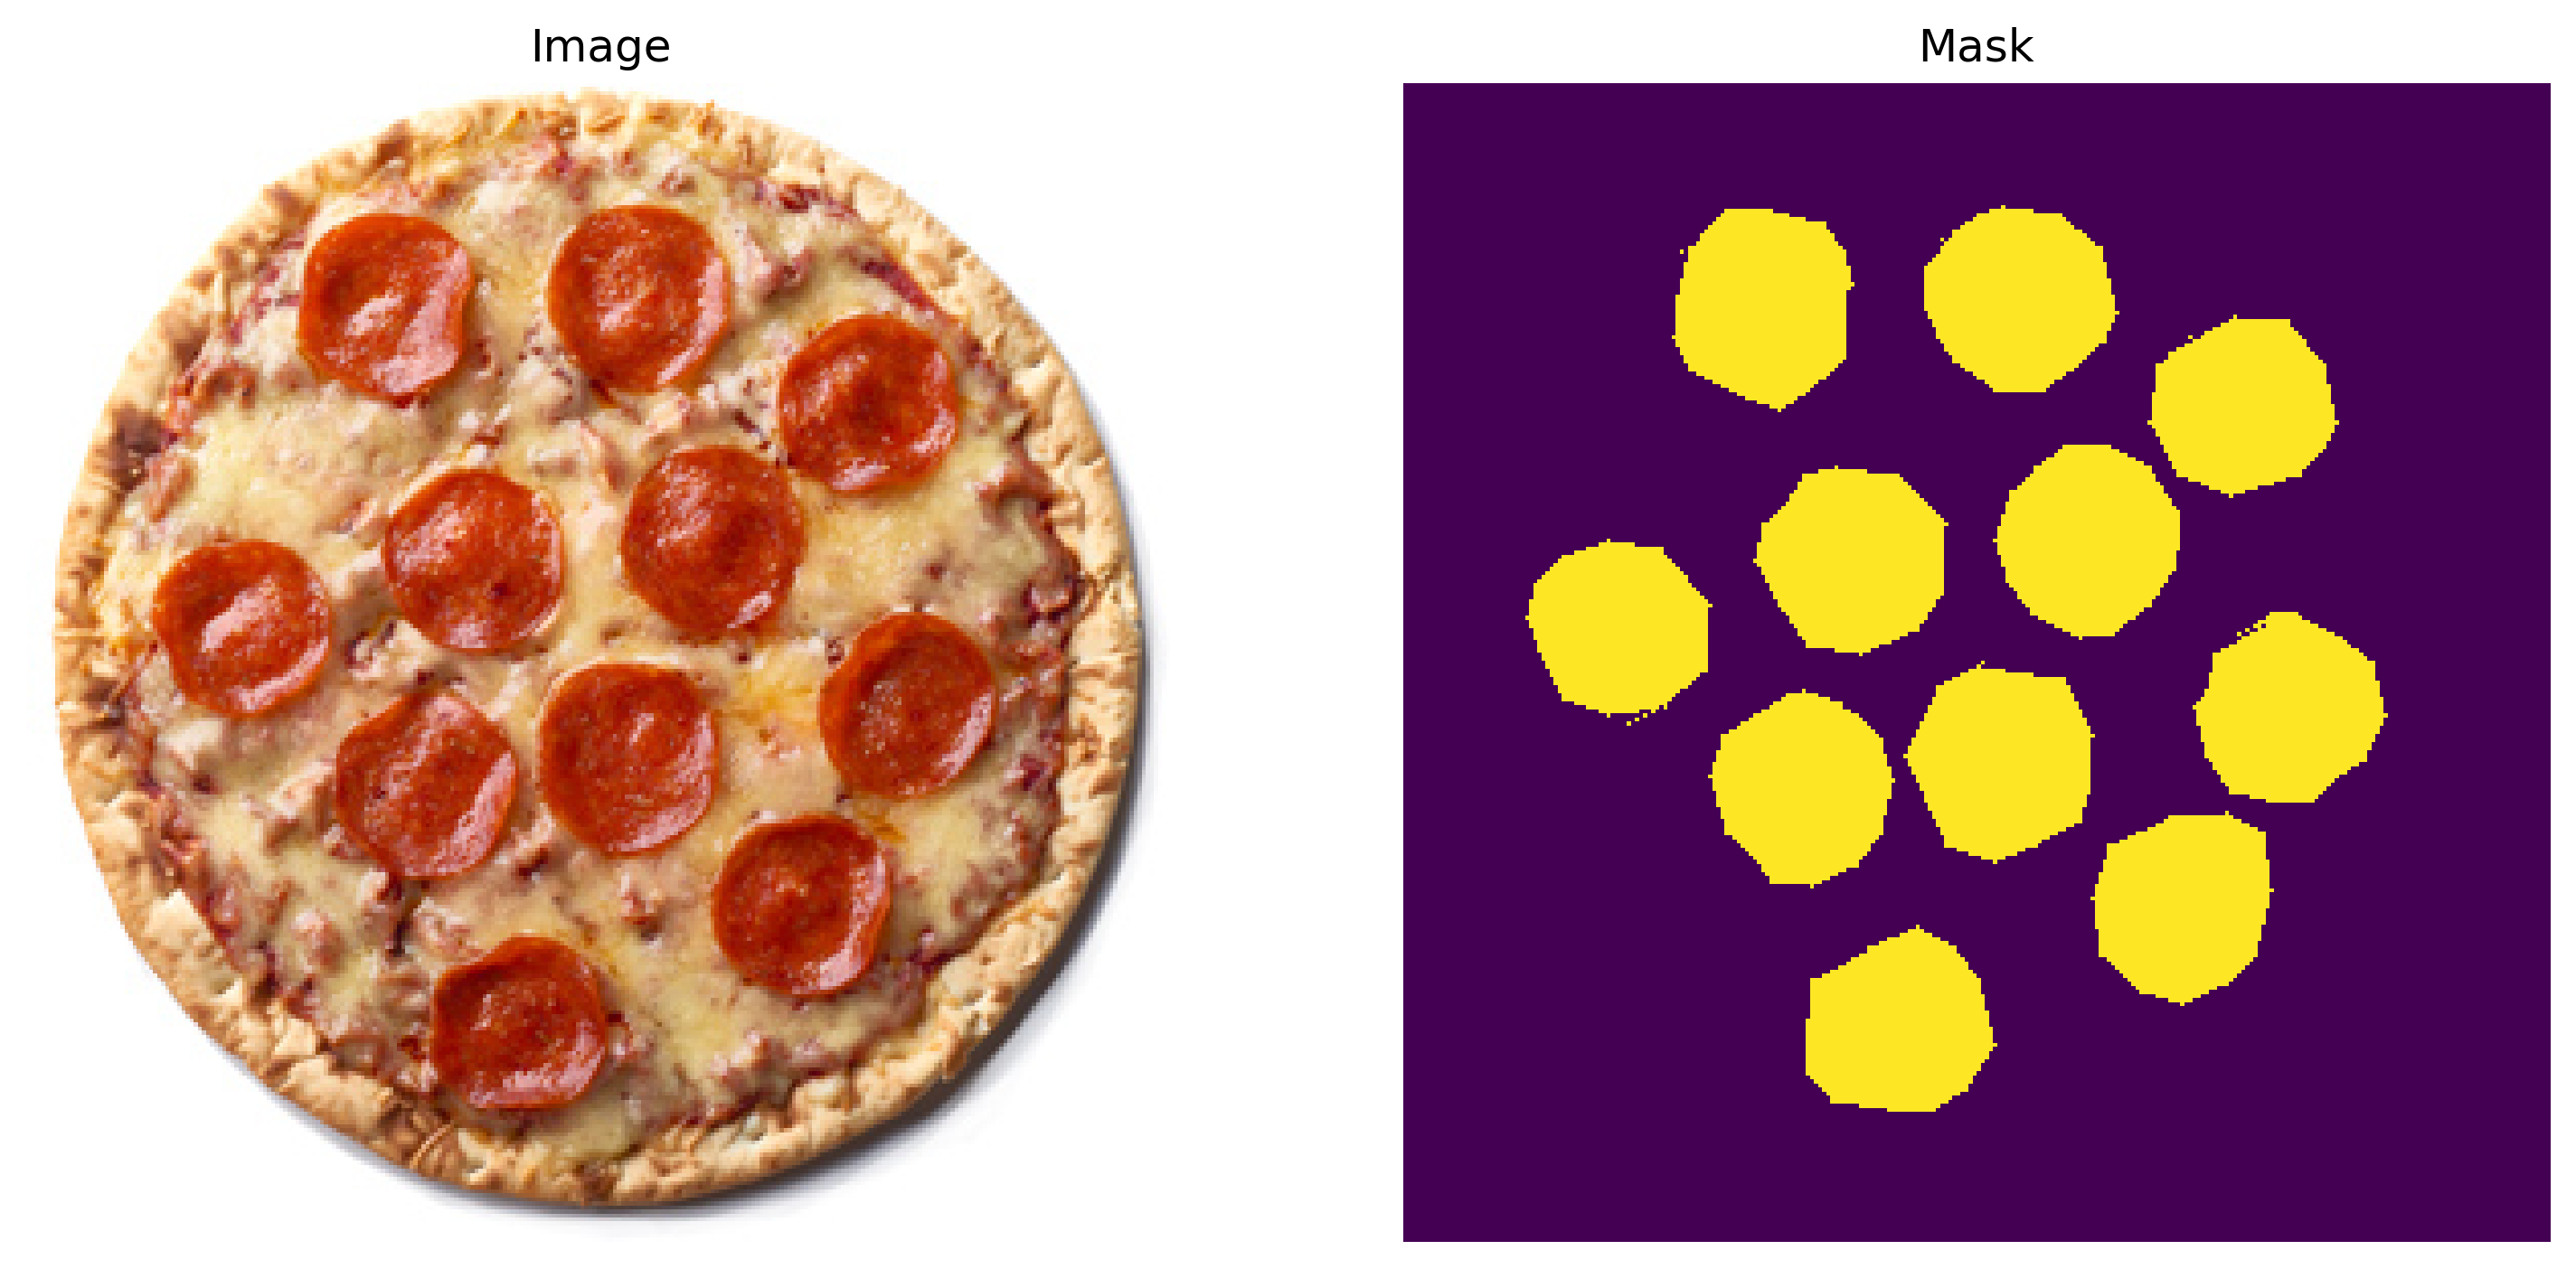

In [160]:
im, mask = ds_val.__getitem__(3)


fig, ax = plt.subplots(1, 2, figsize=(12, 12), dpi=300)
ax[0].imshow(im)
ax[0].set_title('Image')
ax[0].axis('off')
ax[1].imshow(mask)
ax[1].set_title('Mask')
ax[1].axis('off')

In [30]:
def fit_epoch(model, train_loader, criterion, optimizer, th):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    processed_size = 0.0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.float(), labels.float())
        loss.backward()
        optimizer.step()
        preds = (outputs > th).float()
        running_loss += loss.item() * inputs.size(0)
        try:
          running_corrects += iou(preds, labels).sum()
        except:
          running_corrects = 0
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_iou = running_corrects / processed_size
    return val_loss, val_iou

In [68]:
def iou(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1).byte()
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH) # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), min=0, max=10).ceil() / 10  # This is equal to comparing with thresholds
    
    return thresholded  #

In [70]:
def eval_epoch(model, val_loader, criterion, th):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs.float(), labels.float())
            preds = (outputs > th).float()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += iou(preds, labels).sum()
        print('AAAAAAAAAAAAAAAAAAAAA', iou(preds, labels).sum())
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    print('HERE', running_corrects, processed_size, 'HERE')
    val_iou = running_corrects / processed_size
    return val_loss, val_iou

In [29]:
def train(train_dataset, val_dataset, model, epochs, batch_size, th=0.5):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    best_model_wts = model.state_dict()
    best_acc = 0.0

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=0.0003)
        criterion = nn.BCELoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, th)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion, th)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            if val_acc > best_acc:
                best_acc = val_acc
                best_model_wts = model.state_dict()

    model.load_state_dict(best_model_wts)
            
    return model, history

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    
    
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return F.sigmoid(logits)

In [75]:
unet = UNet(3, 1).cuda()
DEVICE = 'cuda'
model_1, h = train(ds_train, ds_val, model=unet, epochs=500, batch_size=24, th=0.2)

epoch:   0%|          | 1/500 [00:01<15:10,  1.83s/it]

loss 0.5307486057281494
AAAAAAAAAAAAAAAAAAAAA tensor(0., device='cuda:0')
HERE tensor(0., device='cuda:0') 4 HERE

Epoch 001 train_loss: 0.5307     val_loss 0.6696 train_acc 0.0000 val_acc 0.0000


epoch:   0%|          | 2/500 [00:03<14:37,  1.76s/it]

loss 0.665357232093811
AAAAAAAAAAAAAAAAAAAAA tensor(0., device='cuda:0')
HERE tensor(0., device='cuda:0') 4 HERE

Epoch 002 train_loss: 0.6654     val_loss 0.6644 train_acc 0.0000 val_acc 0.0000


epoch:   1%|          | 3/500 [00:05<14:23,  1.74s/it]

loss 0.6598785519599915
AAAAAAAAAAAAAAAAAAAAA tensor(0., device='cuda:0')
HERE tensor(0., device='cuda:0') 4 HERE

Epoch 003 train_loss: 0.6599     val_loss 0.6582 train_acc 0.0000 val_acc 0.0000


epoch:   1%|          | 4/500 [00:06<14:18,  1.73s/it]

loss 0.6532800793647766
AAAAAAAAAAAAAAAAAAAAA tensor(0., device='cuda:0')
HERE tensor(0., device='cuda:0') 4 HERE

Epoch 004 train_loss: 0.6533     val_loss 0.6504 train_acc 0.0000 val_acc 0.0000


epoch:   1%|          | 5/500 [00:08<14:15,  1.73s/it]

loss 0.6449427604675293
AAAAAAAAAAAAAAAAAAAAA tensor(0., device='cuda:0')
HERE tensor(0., device='cuda:0') 4 HERE

Epoch 005 train_loss: 0.6449     val_loss 0.6410 train_acc 0.0000 val_acc 0.0000


epoch:   1%|          | 6/500 [00:10<14:10,  1.72s/it]

loss 0.6347330808639526
AAAAAAAAAAAAAAAAAAAAA tensor(0., device='cuda:0')
HERE tensor(0., device='cuda:0') 4 HERE

Epoch 006 train_loss: 0.6347     val_loss 0.6293 train_acc 0.0000 val_acc 0.0000


epoch:   1%|▏         | 7/500 [00:12<14:06,  1.72s/it]

loss 0.6221390962600708
AAAAAAAAAAAAAAAAAAAAA tensor(0., device='cuda:0')
HERE tensor(0., device='cuda:0') 4 HERE

Epoch 007 train_loss: 0.6221     val_loss 0.6147 train_acc 0.0000 val_acc 0.0000


epoch:   2%|▏         | 8/500 [00:13<14:03,  1.71s/it]

loss 0.6061952710151672
AAAAAAAAAAAAAAAAAAAAA tensor(0., device='cuda:0')
HERE tensor(0., device='cuda:0') 4 HERE

Epoch 008 train_loss: 0.6062     val_loss 0.5961 train_acc 0.0000 val_acc 0.0000


epoch:   2%|▏         | 9/500 [00:15<14:01,  1.71s/it]

loss 0.5860581398010254
AAAAAAAAAAAAAAAAAAAAA tensor(0., device='cuda:0')
HERE tensor(0., device='cuda:0') 4 HERE

Epoch 009 train_loss: 0.5861     val_loss 0.5739 train_acc 0.0000 val_acc 0.0000


epoch:   2%|▏         | 10/500 [00:17<13:59,  1.71s/it]

loss 0.5616775155067444
AAAAAAAAAAAAAAAAAAAAA tensor(0., device='cuda:0')
HERE tensor(0., device='cuda:0') 4 HERE

Epoch 010 train_loss: 0.5617     val_loss 0.5474 train_acc 0.0000 val_acc 0.0000


epoch:   2%|▏         | 11/500 [00:18<13:59,  1.72s/it]

loss 0.5325457453727722
AAAAAAAAAAAAAAAAAAAAA tensor(0., device='cuda:0')
HERE tensor(0., device='cuda:0') 4 HERE

Epoch 011 train_loss: 0.5325     val_loss 0.5176 train_acc 0.0000 val_acc 0.0000


epoch:   2%|▏         | 12/500 [00:20<13:59,  1.72s/it]

loss 0.49926838278770447
AAAAAAAAAAAAAAAAAAAAA tensor(0., device='cuda:0')
HERE tensor(0., device='cuda:0') 4 HERE

Epoch 012 train_loss: 0.4993     val_loss 0.4860 train_acc 0.0000 val_acc 0.0000


epoch:   3%|▎         | 13/500 [00:22<13:58,  1.72s/it]

loss 0.46320658922195435
AAAAAAAAAAAAAAAAAAAAA tensor(0., device='cuda:0')
HERE tensor(0., device='cuda:0') 4 HERE

Epoch 013 train_loss: 0.4632     val_loss 0.4548 train_acc 0.0000 val_acc 0.0000


epoch:   3%|▎         | 14/500 [00:24<13:59,  1.73s/it]

loss 0.42652833461761475
AAAAAAAAAAAAAAAAAAAAA tensor(0., device='cuda:0')
HERE tensor(0., device='cuda:0') 4 HERE

Epoch 014 train_loss: 0.4265     val_loss 0.4278 train_acc 0.0000 val_acc 0.0000


epoch:   3%|▎         | 15/500 [00:25<13:58,  1.73s/it]

loss 0.392469584941864
AAAAAAAAAAAAAAAAAAAAA tensor(0.1000, device='cuda:0')
HERE tensor(0.1000, device='cuda:0') 4 HERE

Epoch 015 train_loss: 0.3925     val_loss 0.4091 train_acc 0.0208 val_acc 0.0250


epoch:   3%|▎         | 16/500 [00:27<14:00,  1.74s/it]

loss 0.3648677468299866
AAAAAAAAAAAAAAAAAAAAA tensor(0.3000, device='cuda:0')
HERE tensor(0.3000, device='cuda:0') 4 HERE

Epoch 016 train_loss: 0.3649     val_loss 0.4035 train_acc 0.0833 val_acc 0.0750


epoch:   3%|▎         | 17/500 [00:29<14:02,  1.74s/it]

loss 0.3479970097541809
AAAAAAAAAAAAAAAAAAAAA tensor(0., device='cuda:0')
HERE tensor(0., device='cuda:0') 4 HERE

Epoch 017 train_loss: 0.3480     val_loss 0.4144 train_acc 0.0208 val_acc 0.0000


epoch:   4%|▎         | 18/500 [00:31<14:03,  1.75s/it]

loss 0.3452368974685669
AAAAAAAAAAAAAAAAAAAAA tensor(0., device='cuda:0')
HERE tensor(0., device='cuda:0') 4 HERE

Epoch 018 train_loss: 0.3452     val_loss 0.4384 train_acc 0.0083 val_acc 0.0000


epoch:   4%|▍         | 19/500 [00:32<14:02,  1.75s/it]

loss 0.3551154136657715
AAAAAAAAAAAAAAAAAAAAA tensor(0., device='cuda:0')
HERE tensor(0., device='cuda:0') 4 HERE

Epoch 019 train_loss: 0.3551     val_loss 0.4599 train_acc 0.0000 val_acc 0.0000


epoch:   4%|▍         | 20/500 [00:34<14:01,  1.75s/it]

loss 0.3670070767402649
AAAAAAAAAAAAAAAAAAAAA tensor(0., device='cuda:0')
HERE tensor(0., device='cuda:0') 4 HERE

Epoch 020 train_loss: 0.3670     val_loss 0.4699 train_acc 0.0000 val_acc 0.0000


epoch:   4%|▍         | 21/500 [00:36<14:00,  1.75s/it]

loss 0.3731812536716461
AAAAAAAAAAAAAAAAAAAAA tensor(0., device='cuda:0')
HERE tensor(0., device='cuda:0') 4 HERE

Epoch 021 train_loss: 0.3732     val_loss 0.4693 train_acc 0.0000 val_acc 0.0000


epoch:   4%|▍         | 22/500 [00:38<13:59,  1.76s/it]

loss 0.3730863332748413
AAAAAAAAAAAAAAAAAAAAA tensor(0., device='cuda:0')
HERE tensor(0., device='cuda:0') 4 HERE

Epoch 022 train_loss: 0.3731     val_loss 0.4615 train_acc 0.0000 val_acc 0.0000


epoch:   5%|▍         | 23/500 [00:39<13:59,  1.76s/it]

loss 0.36868250370025635
AAAAAAAAAAAAAAAAAAAAA tensor(0., device='cuda:0')
HERE tensor(0., device='cuda:0') 4 HERE

Epoch 023 train_loss: 0.3687     val_loss 0.4498 train_acc 0.0000 val_acc 0.0000


epoch:   5%|▍         | 24/500 [00:41<13:58,  1.76s/it]

loss 0.361939013004303
AAAAAAAAAAAAAAAAAAAAA tensor(0., device='cuda:0')
HERE tensor(0., device='cuda:0') 4 HERE

Epoch 024 train_loss: 0.3619     val_loss 0.4363 train_acc 0.0000 val_acc 0.0000


epoch:   5%|▌         | 25/500 [00:43<13:58,  1.76s/it]

loss 0.3542712926864624
AAAAAAAAAAAAAAAAAAAAA tensor(0., device='cuda:0')
HERE tensor(0., device='cuda:0') 4 HERE

Epoch 025 train_loss: 0.3543     val_loss 0.4226 train_acc 0.0000 val_acc 0.0000


epoch:   5%|▌         | 26/500 [00:45<13:56,  1.76s/it]

loss 0.34666988253593445
AAAAAAAAAAAAAAAAAAAAA tensor(0., device='cuda:0')
HERE tensor(0., device='cuda:0') 4 HERE

Epoch 026 train_loss: 0.3467     val_loss 0.4093 train_acc 0.0000 val_acc 0.0000


epoch:   5%|▌         | 27/500 [00:47<13:54,  1.76s/it]

loss 0.33970907330513
AAAAAAAAAAAAAAAAAAAAA tensor(0., device='cuda:0')
HERE tensor(0., device='cuda:0') 4 HERE

Epoch 027 train_loss: 0.3397     val_loss 0.3962 train_acc 0.0083 val_acc 0.0000


epoch:   6%|▌         | 28/500 [00:48<13:55,  1.77s/it]

loss 0.3333672881126404
AAAAAAAAAAAAAAAAAAAAA tensor(0.3000, device='cuda:0')
HERE tensor(0.3000, device='cuda:0') 4 HERE

Epoch 028 train_loss: 0.3334     val_loss 0.3826 train_acc 0.0125 val_acc 0.0750


epoch:   6%|▌         | 29/500 [00:50<13:56,  1.77s/it]

loss 0.32795095443725586
AAAAAAAAAAAAAAAAAAAAA tensor(0.2000, device='cuda:0')
HERE tensor(0.2000, device='cuda:0') 4 HERE

Epoch 029 train_loss: 0.3280     val_loss 0.3494 train_acc 0.0208 val_acc 0.0500


epoch:   6%|▌         | 30/500 [00:52<13:56,  1.78s/it]

loss 0.32226186990737915
AAAAAAAAAAAAAAAAAAAAA tensor(0.5000, device='cuda:0')
HERE tensor(0.5000, device='cuda:0') 4 HERE

Epoch 030 train_loss: 0.3223     val_loss 0.3563 train_acc 0.1250 val_acc 0.1250


epoch:   6%|▌         | 31/500 [00:54<13:56,  1.78s/it]

loss 0.32203948497772217
AAAAAAAAAAAAAAAAAAAAA tensor(0.6000, device='cuda:0')
HERE tensor(0.6000, device='cuda:0') 4 HERE

Epoch 031 train_loss: 0.3220     val_loss 0.3589 train_acc 0.1125 val_acc 0.1500


epoch:   6%|▋         | 32/500 [00:56<13:59,  1.79s/it]

loss 0.3219076991081238
AAAAAAAAAAAAAAAAAAAAA tensor(0.5000, device='cuda:0')
HERE tensor(0.5000, device='cuda:0') 4 HERE

Epoch 032 train_loss: 0.3219     val_loss 0.3571 train_acc 0.1125 val_acc 0.1250


epoch:   7%|▋         | 33/500 [00:57<13:59,  1.80s/it]

loss 0.3210409879684448
AAAAAAAAAAAAAAAAAAAAA tensor(0.3000, device='cuda:0')
HERE tensor(0.3000, device='cuda:0') 4 HERE

Epoch 033 train_loss: 0.3210     val_loss 0.3523 train_acc 0.1125 val_acc 0.0750


epoch:   7%|▋         | 34/500 [00:59<13:56,  1.79s/it]

loss 0.31940242648124695
AAAAAAAAAAAAAAAAAAAAA tensor(0.2000, device='cuda:0')
HERE tensor(0.2000, device='cuda:0') 4 HERE

Epoch 034 train_loss: 0.3194     val_loss 0.3465 train_acc 0.1167 val_acc 0.0500


epoch:   7%|▋         | 35/500 [01:01<13:52,  1.79s/it]

loss 0.3168816864490509
AAAAAAAAAAAAAAAAAAAAA tensor(0.2000, device='cuda:0')
HERE tensor(0.2000, device='cuda:0') 4 HERE

Epoch 035 train_loss: 0.3169     val_loss 0.3432 train_acc 0.1125 val_acc 0.0500


epoch:   7%|▋         | 36/500 [01:03<13:52,  1.79s/it]

loss 0.3126695454120636
AAAAAAAAAAAAAAAAAAAAA tensor(0.1000, device='cuda:0')
HERE tensor(0.1000, device='cuda:0') 4 HERE

Epoch 036 train_loss: 0.3127     val_loss 0.3357 train_acc 0.1083 val_acc 0.0250


epoch:   7%|▋         | 37/500 [01:05<13:53,  1.80s/it]

loss 0.30663490295410156
AAAAAAAAAAAAAAAAAAAAA tensor(0.4000, device='cuda:0')
HERE tensor(0.4000, device='cuda:0') 4 HERE

Epoch 037 train_loss: 0.3066     val_loss 0.3453 train_acc 0.0917 val_acc 0.1000


epoch:   8%|▊         | 38/500 [01:06<13:58,  1.81s/it]

loss 0.3064318597316742
AAAAAAAAAAAAAAAAAAAAA tensor(0., device='cuda:0')
HERE tensor(0., device='cuda:0') 4 HERE

Epoch 038 train_loss: 0.3064     val_loss 0.3277 train_acc 0.1125 val_acc 0.0000


epoch:   8%|▊         | 39/500 [01:08<13:56,  1.81s/it]

loss 0.2957572937011719
AAAAAAAAAAAAAAAAAAAAA tensor(0.7000, device='cuda:0')
HERE tensor(0.7000, device='cuda:0') 4 HERE

Epoch 039 train_loss: 0.2958     val_loss 0.3453 train_acc 0.0583 val_acc 0.1750


epoch:   8%|▊         | 40/500 [01:10<13:57,  1.82s/it]

loss 0.3041190803050995
AAAAAAAAAAAAAAAAAAAAA tensor(0.8000, device='cuda:0')
HERE tensor(0.8000, device='cuda:0') 4 HERE

Epoch 040 train_loss: 0.3041     val_loss 0.3469 train_acc 0.1042 val_acc 0.2000


epoch:   8%|▊         | 41/500 [01:12<13:55,  1.82s/it]

loss 0.30494147539138794
AAAAAAAAAAAAAAAAAAAAA tensor(0.7000, device='cuda:0')
HERE tensor(0.7000, device='cuda:0') 4 HERE

Epoch 041 train_loss: 0.3049     val_loss 0.3304 train_acc 0.0958 val_acc 0.1750


epoch:   8%|▊         | 42/500 [01:14<13:56,  1.83s/it]

loss 0.294002503156662
AAAAAAAAAAAAAAAAAAAAA tensor(0., device='cuda:0')
HERE tensor(0., device='cuda:0') 4 HERE

Epoch 042 train_loss: 0.2940     val_loss 0.3337 train_acc 0.1125 val_acc 0.0000


epoch:   9%|▊         | 43/500 [01:16<14:00,  1.84s/it]

loss 0.30117133259773254
AAAAAAAAAAAAAAAAAAAAA tensor(0.7000, device='cuda:0')
HERE tensor(0.7000, device='cuda:0') 4 HERE

Epoch 043 train_loss: 0.3012     val_loss 0.3236 train_acc 0.0375 val_acc 0.1750


epoch:   9%|▉         | 44/500 [01:17<13:58,  1.84s/it]

loss 0.28802329301834106
AAAAAAAAAAAAAAAAAAAAA tensor(0.7000, device='cuda:0')
HERE tensor(0.7000, device='cuda:0') 4 HERE

Epoch 044 train_loss: 0.2880     val_loss 0.3464 train_acc 0.1125 val_acc 0.1750


epoch:   9%|▉         | 45/500 [01:19<13:58,  1.84s/it]

loss 0.3029751181602478
AAAAAAAAAAAAAAAAAAAAA tensor(0.6000, device='cuda:0')
HERE tensor(0.6000, device='cuda:0') 4 HERE

Epoch 045 train_loss: 0.3030     val_loss 0.3507 train_acc 0.0667 val_acc 0.1500


epoch:   9%|▉         | 46/500 [01:21<13:58,  1.85s/it]

loss 0.3058708608150482
AAAAAAAAAAAAAAAAAAAAA tensor(0.7000, device='cuda:0')
HERE tensor(0.7000, device='cuda:0') 4 HERE

Epoch 046 train_loss: 0.3059     val_loss 0.3436 train_acc 0.0583 val_acc 0.1750


epoch:   9%|▉         | 47/500 [01:23<14:04,  1.86s/it]

loss 0.30173468589782715
AAAAAAAAAAAAAAAAAAAAA tensor(0.8000, device='cuda:0')
HERE tensor(0.8000, device='cuda:0') 4 HERE

Epoch 047 train_loss: 0.3017     val_loss 0.3222 train_acc 0.0667 val_acc 0.2000


epoch:  10%|▉         | 48/500 [01:25<14:23,  1.91s/it]

loss 0.2878721058368683
AAAAAAAAAAAAAAAAAAAAA tensor(0.3000, device='cuda:0')
HERE tensor(0.3000, device='cuda:0') 4 HERE

Epoch 048 train_loss: 0.2879     val_loss 0.2892 train_acc 0.1000 val_acc 0.0750


epoch:  10%|▉         | 49/500 [01:27<14:15,  1.90s/it]

loss 0.2634445130825043
AAAAAAAAAAAAAAAAAAAAA tensor(0., device='cuda:0')
HERE tensor(0., device='cuda:0') 4 HERE

Epoch 049 train_loss: 0.2634     val_loss 0.3440 train_acc 0.1042 val_acc 0.0000


epoch:  10%|█         | 50/500 [01:29<14:10,  1.89s/it]

loss 0.3033575117588043
AAAAAAAAAAAAAAAAAAAAA tensor(0.2000, device='cuda:0')
HERE tensor(0.2000, device='cuda:0') 4 HERE

Epoch 050 train_loss: 0.3034     val_loss 0.2899 train_acc 0.0292 val_acc 0.0500


epoch:  10%|█         | 51/500 [01:31<14:07,  1.89s/it]

loss 0.25947898626327515
AAAAAAAAAAAAAAAAAAAAA tensor(0.6000, device='cuda:0')
HERE tensor(0.6000, device='cuda:0') 4 HERE

Epoch 051 train_loss: 0.2595     val_loss 0.3038 train_acc 0.0917 val_acc 0.1500


epoch:  10%|█         | 52/500 [01:33<14:04,  1.88s/it]

loss 0.27436214685440063
AAAAAAAAAAAAAAAAAAAAA tensor(0.7000, device='cuda:0')
HERE tensor(0.7000, device='cuda:0') 4 HERE

Epoch 052 train_loss: 0.2744     val_loss 0.3149 train_acc 0.1125 val_acc 0.1750


epoch:  11%|█         | 53/500 [01:34<14:02,  1.89s/it]

loss 0.2818884253501892
AAAAAAAAAAAAAAAAAAAAA tensor(0.7000, device='cuda:0')
HERE tensor(0.7000, device='cuda:0') 4 HERE

Epoch 053 train_loss: 0.2819     val_loss 0.3001 train_acc 0.1125 val_acc 0.1750


epoch:  11%|█         | 54/500 [01:36<14:02,  1.89s/it]

loss 0.27236542105674744
AAAAAAAAAAAAAAAAAAAAA tensor(0.4000, device='cuda:0')
HERE tensor(0.4000, device='cuda:0') 4 HERE

Epoch 054 train_loss: 0.2724     val_loss 0.2809 train_acc 0.1167 val_acc 0.1000


epoch:  11%|█         | 55/500 [01:38<14:02,  1.89s/it]

loss 0.255412220954895
AAAAAAAAAAAAAAAAAAAAA tensor(0., device='cuda:0')
HERE tensor(0., device='cuda:0') 4 HERE

Epoch 055 train_loss: 0.2554     val_loss 0.3037 train_acc 0.1042 val_acc 0.0000


epoch:  11%|█         | 56/500 [01:40<14:01,  1.90s/it]

loss 0.2658318877220154
AAAAAAAAAAAAAAAAAAAAA tensor(0., device='cuda:0')
HERE tensor(0., device='cuda:0') 4 HERE

Epoch 056 train_loss: 0.2658     val_loss 0.3023 train_acc 0.0625 val_acc 0.0000


epoch:  11%|█▏        | 57/500 [01:42<13:58,  1.89s/it]

loss 0.26324179768562317
AAAAAAAAAAAAAAAAAAAAA tensor(0.3000, device='cuda:0')
HERE tensor(0.3000, device='cuda:0') 4 HERE

Epoch 057 train_loss: 0.2632     val_loss 0.2752 train_acc 0.0625 val_acc 0.0750


epoch:  12%|█▏        | 58/500 [01:44<13:57,  1.89s/it]

loss 0.24906983971595764
AAAAAAAAAAAAAAAAAAAAA tensor(0.6000, device='cuda:0')
HERE tensor(0.6000, device='cuda:0') 4 HERE

Epoch 058 train_loss: 0.2491     val_loss 0.2791 train_acc 0.1083 val_acc 0.1500


epoch:  12%|█▏        | 59/500 [01:46<13:56,  1.90s/it]

loss 0.2568635046482086
AAAAAAAAAAAAAAAAAAAAA tensor(0.5000, device='cuda:0')
HERE tensor(0.5000, device='cuda:0') 4 HERE

Epoch 059 train_loss: 0.2569     val_loss 0.2790 train_acc 0.1208 val_acc 0.1250


epoch:  12%|█▏        | 60/500 [01:48<13:55,  1.90s/it]

loss 0.25302496552467346
AAAAAAAAAAAAAAAAAAAAA tensor(0.2000, device='cuda:0')
HERE tensor(0.2000, device='cuda:0') 4 HERE

Epoch 060 train_loss: 0.2530     val_loss 0.2749 train_acc 0.1125 val_acc 0.0500


epoch:  12%|█▏        | 61/500 [01:50<13:50,  1.89s/it]

loss 0.24169345200061798
AAAAAAAAAAAAAAAAAAAAA tensor(0., device='cuda:0')
HERE tensor(0., device='cuda:0') 4 HERE

Epoch 061 train_loss: 0.2417     val_loss 0.3043 train_acc 0.0917 val_acc 0.0000


epoch:  12%|█▏        | 62/500 [01:51<13:48,  1.89s/it]

loss 0.24829253554344177
AAAAAAAAAAAAAAAAAAAAA tensor(0.1000, device='cuda:0')
HERE tensor(0.1000, device='cuda:0') 4 HERE

Epoch 062 train_loss: 0.2483     val_loss 0.2834 train_acc 0.0583 val_acc 0.0250


epoch:  13%|█▎        | 63/500 [01:53<13:45,  1.89s/it]

loss 0.23774480819702148
AAAAAAAAAAAAAAAAAAAAA tensor(0.4000, device='cuda:0')
HERE tensor(0.4000, device='cuda:0') 4 HERE

Epoch 063 train_loss: 0.2377     val_loss 0.2641 train_acc 0.0708 val_acc 0.1000


epoch:  13%|█▎        | 64/500 [01:55<13:43,  1.89s/it]

loss 0.2367749959230423
AAAAAAAAAAAAAAAAAAAAA tensor(0.5000, device='cuda:0')
HERE tensor(0.5000, device='cuda:0') 4 HERE

Epoch 064 train_loss: 0.2368     val_loss 0.2602 train_acc 0.1167 val_acc 0.1250


epoch:  13%|█▎        | 65/500 [01:57<13:36,  1.88s/it]

loss 0.23337256908416748
AAAAAAAAAAAAAAAAAAAAA tensor(0.2000, device='cuda:0')
HERE tensor(0.2000, device='cuda:0') 4 HERE

Epoch 065 train_loss: 0.2334     val_loss 0.2615 train_acc 0.1250 val_acc 0.0500


epoch:  13%|█▎        | 66/500 [01:59<13:31,  1.87s/it]

loss 0.22900035977363586
AAAAAAAAAAAAAAAAAAAAA tensor(0.1000, device='cuda:0')
HERE tensor(0.1000, device='cuda:0') 4 HERE

Epoch 066 train_loss: 0.2290     val_loss 0.2652 train_acc 0.1042 val_acc 0.0250


epoch:  13%|█▎        | 67/500 [02:01<13:25,  1.86s/it]

loss 0.22681033611297607
AAAAAAAAAAAAAAAAAAAAA tensor(0.5000, device='cuda:0')
HERE tensor(0.5000, device='cuda:0') 4 HERE

Epoch 067 train_loss: 0.2268     val_loss 0.2544 train_acc 0.0875 val_acc 0.1250


epoch:  14%|█▎        | 68/500 [02:03<13:21,  1.86s/it]

loss 0.22134056687355042
AAAAAAAAAAAAAAAAAAAAA tensor(0.4000, device='cuda:0')
HERE tensor(0.4000, device='cuda:0') 4 HERE

Epoch 068 train_loss: 0.2213     val_loss 0.2551 train_acc 0.1250 val_acc 0.1000


epoch:  14%|█▍        | 69/500 [02:04<13:16,  1.85s/it]

loss 0.21586140990257263
AAAAAAAAAAAAAAAAAAAAA tensor(0.1000, device='cuda:0')
HERE tensor(0.1000, device='cuda:0') 4 HERE

Epoch 069 train_loss: 0.2159     val_loss 0.2798 train_acc 0.1167 val_acc 0.0250


epoch:  14%|█▍        | 70/500 [02:06<13:11,  1.84s/it]

loss 0.22207917273044586
AAAAAAAAAAAAAAAAAAAAA tensor(0.5000, device='cuda:0')
HERE tensor(0.5000, device='cuda:0') 4 HERE

Epoch 070 train_loss: 0.2221     val_loss 0.2493 train_acc 0.0667 val_acc 0.1250


epoch:  14%|█▍        | 71/500 [02:08<13:05,  1.83s/it]

loss 0.21529553830623627
AAAAAAAAAAAAAAAAAAAAA tensor(0.5000, device='cuda:0')
HERE tensor(0.5000, device='cuda:0') 4 HERE

Epoch 071 train_loss: 0.2153     val_loss 0.2436 train_acc 0.1667 val_acc 0.1250


epoch:  14%|█▍        | 72/500 [02:10<13:02,  1.83s/it]

loss 0.20562268793582916
AAAAAAAAAAAAAAAAAAAAA tensor(0.1000, device='cuda:0')
HERE tensor(0.1000, device='cuda:0') 4 HERE

Epoch 072 train_loss: 0.2056     val_loss 0.2589 train_acc 0.1333 val_acc 0.0250


epoch:  15%|█▍        | 73/500 [02:12<13:01,  1.83s/it]

loss 0.20860904455184937
AAAAAAAAAAAAAAAAAAAAA tensor(0.8000, device='cuda:0')
HERE tensor(0.8000, device='cuda:0') 4 HERE

Epoch 073 train_loss: 0.2086     val_loss 0.2523 train_acc 0.1000 val_acc 0.2000


epoch:  15%|█▍        | 74/500 [02:14<13:00,  1.83s/it]

loss 0.2190738320350647
AAAAAAAAAAAAAAAAAAAAA tensor(0., device='cuda:0')
HERE tensor(0., device='cuda:0') 4 HERE

Epoch 074 train_loss: 0.2191     val_loss 0.2868 train_acc 0.1833 val_acc 0.0000


epoch:  15%|█▌        | 75/500 [02:15<12:57,  1.83s/it]

loss 0.21906620264053345
AAAAAAAAAAAAAAAAAAAAA tensor(0.6000, device='cuda:0')
HERE tensor(0.6000, device='cuda:0') 4 HERE

Epoch 075 train_loss: 0.2191     val_loss 0.2668 train_acc 0.0625 val_acc 0.1500


epoch:  15%|█▌        | 76/500 [02:17<12:52,  1.82s/it]

loss 0.220637246966362
AAAAAAAAAAAAAAAAAAAAA tensor(0.3000, device='cuda:0')
HERE tensor(0.3000, device='cuda:0') 4 HERE

Epoch 076 train_loss: 0.2206     val_loss 0.2340 train_acc 0.1708 val_acc 0.0750


epoch:  15%|█▌        | 77/500 [02:19<12:51,  1.82s/it]

loss 0.20077495276927948
AAAAAAAAAAAAAAAAAAAAA tensor(0.3000, device='cuda:0')
HERE tensor(0.3000, device='cuda:0') 4 HERE

Epoch 077 train_loss: 0.2008     val_loss 0.2331 train_acc 0.1292 val_acc 0.0750


epoch:  16%|█▌        | 78/500 [02:21<12:49,  1.82s/it]

loss 0.21187591552734375
AAAAAAAAAAAAAAAAAAAAA tensor(0.7000, device='cuda:0')
HERE tensor(0.7000, device='cuda:0') 4 HERE

Epoch 078 train_loss: 0.2119     val_loss 0.2257 train_acc 0.1417 val_acc 0.1750


epoch:  16%|█▌        | 79/500 [02:23<12:48,  1.82s/it]

loss 0.20414938032627106
AAAAAAAAAAAAAAAAAAAAA tensor(0.4000, device='cuda:0')
HERE tensor(0.4000, device='cuda:0') 4 HERE

Epoch 079 train_loss: 0.2041     val_loss 0.2337 train_acc 0.1708 val_acc 0.1000


epoch:  16%|█▌        | 80/500 [02:24<12:45,  1.82s/it]

loss 0.192501038312912
AAAAAAAAAAAAAAAAAAAAA tensor(0.3000, device='cuda:0')
HERE tensor(0.3000, device='cuda:0') 4 HERE

Epoch 080 train_loss: 0.1925     val_loss 0.2509 train_acc 0.1458 val_acc 0.0750


epoch:  16%|█▌        | 81/500 [02:26<12:45,  1.83s/it]

loss 0.1955185830593109
AAAAAAAAAAAAAAAAAAAAA tensor(0.5000, device='cuda:0')
HERE tensor(0.5000, device='cuda:0') 4 HERE

Epoch 081 train_loss: 0.1955     val_loss 0.2543 train_acc 0.1333 val_acc 0.1250


epoch:  16%|█▋        | 82/500 [02:28<12:43,  1.83s/it]

loss 0.19904620945453644
AAAAAAAAAAAAAAAAAAAAA tensor(0.2000, device='cuda:0')
HERE tensor(0.2000, device='cuda:0') 4 HERE

Epoch 082 train_loss: 0.1990     val_loss 0.2617 train_acc 0.1583 val_acc 0.0500


epoch:  17%|█▋        | 83/500 [02:30<12:41,  1.83s/it]

loss 0.2008216232061386
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 083 train_loss: 0.2008     val_loss 0.2644 train_acc 0.1000 val_acc 0.2250


epoch:  17%|█▋        | 84/500 [02:32<12:39,  1.82s/it]

loss 0.21951447427272797
AAAAAAAAAAAAAAAAAAAAA tensor(0.5000, device='cuda:0')
HERE tensor(0.5000, device='cuda:0') 4 HERE

Epoch 084 train_loss: 0.2195     val_loss 0.2257 train_acc 0.1875 val_acc 0.1250


epoch:  17%|█▋        | 85/500 [02:34<12:35,  1.82s/it]

loss 0.1912420243024826
AAAAAAAAAAAAAAAAAAAAA tensor(0.2000, device='cuda:0')
HERE tensor(0.2000, device='cuda:0') 4 HERE

Epoch 085 train_loss: 0.1912     val_loss 0.2457 train_acc 0.1250 val_acc 0.0500


epoch:  17%|█▋        | 86/500 [02:35<12:35,  1.83s/it]

loss 0.20751458406448364
AAAAAAAAAAAAAAAAAAAAA tensor(1.2000, device='cuda:0')
HERE tensor(1.2000, device='cuda:0') 4 HERE

Epoch 086 train_loss: 0.2075     val_loss 0.2716 train_acc 0.0833 val_acc 0.3000


epoch:  17%|█▋        | 87/500 [02:37<12:32,  1.82s/it]

loss 0.2262105643749237
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 087 train_loss: 0.2262     val_loss 0.2432 train_acc 0.1875 val_acc 0.2250


epoch:  18%|█▊        | 88/500 [02:39<12:32,  1.83s/it]

loss 0.2024756669998169
AAAAAAAAAAAAAAAAAAAAA tensor(0., device='cuda:0')
HERE tensor(0., device='cuda:0') 4 HERE

Epoch 088 train_loss: 0.2025     val_loss 0.2776 train_acc 0.1917 val_acc 0.0000


epoch:  18%|█▊        | 89/500 [02:41<12:31,  1.83s/it]

loss 0.21848280727863312
AAAAAAAAAAAAAAAAAAAAA tensor(0.6000, device='cuda:0')
HERE tensor(0.6000, device='cuda:0') 4 HERE

Epoch 089 train_loss: 0.2185     val_loss 0.2428 train_acc 0.0625 val_acc 0.1500


epoch:  18%|█▊        | 90/500 [02:43<12:29,  1.83s/it]

loss 0.19623610377311707
AAAAAAAAAAAAAAAAAAAAA tensor(0.7000, device='cuda:0')
HERE tensor(0.7000, device='cuda:0') 4 HERE

Epoch 090 train_loss: 0.1962     val_loss 0.2512 train_acc 0.1917 val_acc 0.1750


epoch:  18%|█▊        | 91/500 [02:45<12:27,  1.83s/it]

loss 0.1994384527206421
AAAAAAAAAAAAAAAAAAAAA tensor(0.5000, device='cuda:0')
HERE tensor(0.5000, device='cuda:0') 4 HERE

Epoch 091 train_loss: 0.1994     val_loss 0.2326 train_acc 0.2083 val_acc 0.1250


epoch:  18%|█▊        | 92/500 [02:46<12:26,  1.83s/it]

loss 0.18291695415973663
AAAAAAAAAAAAAAAAAAAAA tensor(0.1000, device='cuda:0')
HERE tensor(0.1000, device='cuda:0') 4 HERE

Epoch 092 train_loss: 0.1829     val_loss 0.2506 train_acc 0.1417 val_acc 0.0250


epoch:  19%|█▊        | 93/500 [02:48<12:26,  1.83s/it]

loss 0.1966167539358139
AAAAAAAAAAAAAAAAAAAAA tensor(0.5000, device='cuda:0')
HERE tensor(0.5000, device='cuda:0') 4 HERE

Epoch 093 train_loss: 0.1966     val_loss 0.2322 train_acc 0.0792 val_acc 0.1250


epoch:  19%|█▉        | 94/500 [02:50<12:26,  1.84s/it]

loss 0.18382570147514343
AAAAAAAAAAAAAAAAAAAAA tensor(0.7000, device='cuda:0')
HERE tensor(0.7000, device='cuda:0') 4 HERE

Epoch 094 train_loss: 0.1838     val_loss 0.2464 train_acc 0.1667 val_acc 0.1750


epoch:  19%|█▉        | 95/500 [02:52<12:26,  1.84s/it]

loss 0.19311568140983582
AAAAAAAAAAAAAAAAAAAAA tensor(0.5000, device='cuda:0')
HERE tensor(0.5000, device='cuda:0') 4 HERE

Epoch 095 train_loss: 0.1931     val_loss 0.2350 train_acc 0.2000 val_acc 0.1250


epoch:  19%|█▉        | 96/500 [02:54<12:28,  1.85s/it]

loss 0.18230251967906952
AAAAAAAAAAAAAAAAAAAAA tensor(0.1000, device='cuda:0')
HERE tensor(0.1000, device='cuda:0') 4 HERE

Epoch 096 train_loss: 0.1823     val_loss 0.2481 train_acc 0.1792 val_acc 0.0250


epoch:  19%|█▉        | 97/500 [02:56<12:28,  1.86s/it]

loss 0.18793173134326935
AAAAAAAAAAAAAAAAAAAAA tensor(0.2000, device='cuda:0')
HERE tensor(0.2000, device='cuda:0') 4 HERE

Epoch 097 train_loss: 0.1879     val_loss 0.2410 train_acc 0.1083 val_acc 0.0500


epoch:  20%|█▉        | 98/500 [02:58<12:25,  1.85s/it]

loss 0.17984195053577423
AAAAAAAAAAAAAAAAAAAAA tensor(0.6000, device='cuda:0')
HERE tensor(0.6000, device='cuda:0') 4 HERE

Epoch 098 train_loss: 0.1798     val_loss 0.2492 train_acc 0.1500 val_acc 0.1500


epoch:  20%|█▉        | 99/500 [02:59<12:25,  1.86s/it]

loss 0.18452270328998566
AAAAAAAAAAAAAAAAAAAAA tensor(0.5000, device='cuda:0')
HERE tensor(0.5000, device='cuda:0') 4 HERE

Epoch 099 train_loss: 0.1845     val_loss 0.2404 train_acc 0.1958 val_acc 0.1250


epoch:  20%|██        | 100/500 [03:01<12:21,  1.85s/it]

loss 0.17736400663852692
AAAAAAAAAAAAAAAAAAAAA tensor(0.3000, device='cuda:0')
HERE tensor(0.3000, device='cuda:0') 4 HERE

Epoch 100 train_loss: 0.1774     val_loss 0.2425 train_acc 0.1833 val_acc 0.0750


epoch:  20%|██        | 101/500 [03:03<12:19,  1.85s/it]

loss 0.17979183793067932
AAAAAAAAAAAAAAAAAAAAA tensor(0.4000, device='cuda:0')
HERE tensor(0.4000, device='cuda:0') 4 HERE

Epoch 101 train_loss: 0.1798     val_loss 0.2340 train_acc 0.1292 val_acc 0.1000


epoch:  20%|██        | 102/500 [03:05<12:19,  1.86s/it]

loss 0.17397496104240417
AAAAAAAAAAAAAAAAAAAAA tensor(0.6000, device='cuda:0')
HERE tensor(0.6000, device='cuda:0') 4 HERE

Epoch 102 train_loss: 0.1740     val_loss 0.2422 train_acc 0.1583 val_acc 0.1500


epoch:  21%|██        | 103/500 [03:07<12:18,  1.86s/it]

loss 0.17623700201511383
AAAAAAAAAAAAAAAAAAAAA tensor(0.5000, device='cuda:0')
HERE tensor(0.5000, device='cuda:0') 4 HERE

Epoch 103 train_loss: 0.1762     val_loss 0.2409 train_acc 0.2042 val_acc 0.1250


epoch:  21%|██        | 104/500 [03:09<12:16,  1.86s/it]

loss 0.17097632586956024
AAAAAAAAAAAAAAAAAAAAA tensor(0.3000, device='cuda:0')
HERE tensor(0.3000, device='cuda:0') 4 HERE

Epoch 104 train_loss: 0.1710     val_loss 0.2506 train_acc 0.1875 val_acc 0.0750


epoch:  21%|██        | 105/500 [03:11<12:13,  1.86s/it]

loss 0.1735346019268036
AAAAAAAAAAAAAAAAAAAAA tensor(0.5000, device='cuda:0')
HERE tensor(0.5000, device='cuda:0') 4 HERE

Epoch 105 train_loss: 0.1735     val_loss 0.2650 train_acc 0.1500 val_acc 0.1250


epoch:  21%|██        | 106/500 [03:12<12:11,  1.86s/it]

loss 0.17016099393367767
AAAAAAAAAAAAAAAAAAAAA tensor(0.6000, device='cuda:0')
HERE tensor(0.6000, device='cuda:0') 4 HERE

Epoch 106 train_loss: 0.1702     val_loss 0.2325 train_acc 0.1833 val_acc 0.1500


epoch:  21%|██▏       | 107/500 [03:14<12:08,  1.85s/it]

loss 0.16742448508739471
AAAAAAAAAAAAAAAAAAAAA tensor(0.6000, device='cuda:0')
HERE tensor(0.6000, device='cuda:0') 4 HERE

Epoch 107 train_loss: 0.1674     val_loss 0.2223 train_acc 0.1917 val_acc 0.1500


epoch:  22%|██▏       | 108/500 [03:16<12:05,  1.85s/it]

loss 0.16796521842479706
AAAAAAAAAAAAAAAAAAAAA tensor(0.6000, device='cuda:0')
HERE tensor(0.6000, device='cuda:0') 4 HERE

Epoch 108 train_loss: 0.1680     val_loss 0.2219 train_acc 0.1750 val_acc 0.1500


epoch:  22%|██▏       | 109/500 [03:18<12:03,  1.85s/it]

loss 0.16607588529586792
AAAAAAAAAAAAAAAAAAAAA tensor(0.6000, device='cuda:0')
HERE tensor(0.6000, device='cuda:0') 4 HERE

Epoch 109 train_loss: 0.1661     val_loss 0.2290 train_acc 0.1917 val_acc 0.1500


epoch:  22%|██▏       | 110/500 [03:20<12:04,  1.86s/it]

loss 0.1634921282529831
AAAAAAAAAAAAAAAAAAAAA tensor(0.5000, device='cuda:0')
HERE tensor(0.5000, device='cuda:0') 4 HERE

Epoch 110 train_loss: 0.1635     val_loss 0.2434 train_acc 0.2042 val_acc 0.1250


epoch:  22%|██▏       | 111/500 [03:22<12:02,  1.86s/it]

loss 0.16081024706363678
AAAAAAAAAAAAAAAAAAAAA tensor(0.5000, device='cuda:0')
HERE tensor(0.5000, device='cuda:0') 4 HERE

Epoch 111 train_loss: 0.1608     val_loss 0.2492 train_acc 0.2042 val_acc 0.1250


epoch:  22%|██▏       | 112/500 [03:24<11:57,  1.85s/it]

loss 0.16651645302772522
AAAAAAAAAAAAAAAAAAAAA tensor(0., device='cuda:0')
HERE tensor(0., device='cuda:0') 4 HERE

Epoch 112 train_loss: 0.1665     val_loss 0.5380 train_acc 0.2333 val_acc 0.0000


epoch:  23%|██▎       | 113/500 [03:25<11:53,  1.84s/it]

loss 0.3529563248157501
AAAAAAAAAAAAAAAAAAAAA tensor(0., device='cuda:0')
HERE tensor(0., device='cuda:0') 4 HERE

Epoch 113 train_loss: 0.3530     val_loss 0.6970 train_acc 0.0375 val_acc 0.0000


epoch:  23%|██▎       | 114/500 [03:27<11:49,  1.84s/it]

loss 0.5281466245651245
AAAAAAAAAAAAAAAAAAAAA tensor(0., device='cuda:0')
HERE tensor(0., device='cuda:0') 4 HERE

Epoch 114 train_loss: 0.5281     val_loss 0.5678 train_acc 0.0083 val_acc 0.0000


epoch:  23%|██▎       | 115/500 [03:29<11:46,  1.84s/it]

loss 0.435133159160614
AAAAAAAAAAAAAAAAAAAAA tensor(0., device='cuda:0')
HERE tensor(0., device='cuda:0') 4 HERE

Epoch 115 train_loss: 0.4351     val_loss 0.5432 train_acc 0.0000 val_acc 0.0000


epoch:  23%|██▎       | 116/500 [03:31<11:45,  1.84s/it]

loss 0.42674386501312256
AAAAAAAAAAAAAAAAAAAAA tensor(0., device='cuda:0')
HERE tensor(0., device='cuda:0') 4 HERE

Epoch 116 train_loss: 0.4267     val_loss 0.4617 train_acc 0.0000 val_acc 0.0000


epoch:  23%|██▎       | 117/500 [03:33<11:42,  1.84s/it]

loss 0.3692362606525421
AAAAAAAAAAAAAAAAAAAAA tensor(0.2000, device='cuda:0')
HERE tensor(0.2000, device='cuda:0') 4 HERE

Epoch 117 train_loss: 0.3692     val_loss 0.3594 train_acc 0.0250 val_acc 0.0500


epoch:  24%|██▎       | 118/500 [03:35<11:41,  1.84s/it]

loss 0.30061793327331543
AAAAAAAAAAAAAAAAAAAAA tensor(1.3000, device='cuda:0')
HERE tensor(1.3000, device='cuda:0') 4 HERE

Epoch 118 train_loss: 0.3006     val_loss 0.3035 train_acc 0.0500 val_acc 0.3250


epoch:  24%|██▍       | 119/500 [03:36<11:38,  1.83s/it]

loss 0.2677561938762665
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 119 train_loss: 0.2678     val_loss 0.2886 train_acc 0.1292 val_acc 0.2500


epoch:  24%|██▍       | 120/500 [03:38<11:40,  1.84s/it]

loss 0.264000803232193
AAAAAAAAAAAAAAAAAAAAA tensor(0.6000, device='cuda:0')
HERE tensor(0.6000, device='cuda:0') 4 HERE

Epoch 120 train_loss: 0.2640     val_loss 0.2899 train_acc 0.1500 val_acc 0.1500


epoch:  24%|██▍       | 121/500 [03:40<11:37,  1.84s/it]

loss 0.2724340558052063
AAAAAAAAAAAAAAAAAAAAA tensor(0.3000, device='cuda:0')
HERE tensor(0.3000, device='cuda:0') 4 HERE

Epoch 121 train_loss: 0.2724     val_loss 0.2968 train_acc 0.1333 val_acc 0.0750


epoch:  24%|██▍       | 122/500 [03:42<11:35,  1.84s/it]

loss 0.2846856117248535
AAAAAAAAAAAAAAAAAAAAA tensor(0., device='cuda:0')
HERE tensor(0., device='cuda:0') 4 HERE

Epoch 122 train_loss: 0.2847     val_loss 0.3061 train_acc 0.1083 val_acc 0.0000


epoch:  25%|██▍       | 123/500 [03:44<11:31,  1.83s/it]

loss 0.29724347591400146
AAAAAAAAAAAAAAAAAAAAA tensor(0., device='cuda:0')
HERE tensor(0., device='cuda:0') 4 HERE

Epoch 123 train_loss: 0.2972     val_loss 0.3143 train_acc 0.0792 val_acc 0.0000


epoch:  25%|██▍       | 124/500 [03:46<11:29,  1.83s/it]

loss 0.3063197135925293
AAAAAAAAAAAAAAAAAAAAA tensor(0., device='cuda:0')
HERE tensor(0., device='cuda:0') 4 HERE

Epoch 124 train_loss: 0.3063     val_loss 0.3184 train_acc 0.0583 val_acc 0.0000


epoch:  25%|██▌       | 125/500 [03:47<11:27,  1.83s/it]

loss 0.30959612131118774
AAAAAAAAAAAAAAAAAAAAA tensor(0., device='cuda:0')
HERE tensor(0., device='cuda:0') 4 HERE

Epoch 125 train_loss: 0.3096     val_loss 0.3188 train_acc 0.0583 val_acc 0.0000


epoch:  25%|██▌       | 126/500 [03:49<11:24,  1.83s/it]

loss 0.30802232027053833
AAAAAAAAAAAAAAAAAAAAA tensor(0.1000, device='cuda:0')
HERE tensor(0.1000, device='cuda:0') 4 HERE

Epoch 126 train_loss: 0.3080     val_loss 0.3174 train_acc 0.0625 val_acc 0.0250


epoch:  25%|██▌       | 127/500 [03:51<11:22,  1.83s/it]

loss 0.3040247857570648
AAAAAAAAAAAAAAAAAAAAA tensor(0.2000, device='cuda:0')
HERE tensor(0.2000, device='cuda:0') 4 HERE

Epoch 127 train_loss: 0.3040     val_loss 0.3147 train_acc 0.0833 val_acc 0.0500


epoch:  26%|██▌       | 128/500 [03:53<11:20,  1.83s/it]

loss 0.29915672540664673
AAAAAAAAAAAAAAAAAAAAA tensor(0.3000, device='cuda:0')
HERE tensor(0.3000, device='cuda:0') 4 HERE

Epoch 128 train_loss: 0.2992     val_loss 0.3099 train_acc 0.0917 val_acc 0.0750


epoch:  26%|██▌       | 129/500 [03:55<11:18,  1.83s/it]

loss 0.29330119490623474
AAAAAAAAAAAAAAAAAAAAA tensor(0.3000, device='cuda:0')
HERE tensor(0.3000, device='cuda:0') 4 HERE

Epoch 129 train_loss: 0.2933     val_loss 0.3020 train_acc 0.0958 val_acc 0.0750


epoch:  26%|██▌       | 130/500 [03:57<11:18,  1.83s/it]

loss 0.2856885492801666
AAAAAAAAAAAAAAAAAAAAA tensor(0.4000, device='cuda:0')
HERE tensor(0.4000, device='cuda:0') 4 HERE

Epoch 130 train_loss: 0.2857     val_loss 0.2902 train_acc 0.1083 val_acc 0.1000


epoch:  26%|██▌       | 131/500 [03:58<11:17,  1.84s/it]

loss 0.2757778763771057
AAAAAAAAAAAAAAAAAAAAA tensor(0.6000, device='cuda:0')
HERE tensor(0.6000, device='cuda:0') 4 HERE

Epoch 131 train_loss: 0.2758     val_loss 0.2773 train_acc 0.1167 val_acc 0.1500


epoch:  26%|██▋       | 132/500 [04:00<11:15,  1.83s/it]

loss 0.2647447884082794
AAAAAAAAAAAAAAAAAAAAA tensor(1.2000, device='cuda:0')
HERE tensor(1.2000, device='cuda:0') 4 HERE

Epoch 132 train_loss: 0.2647     val_loss 0.2817 train_acc 0.1292 val_acc 0.3000


epoch:  27%|██▋       | 133/500 [04:02<11:15,  1.84s/it]

loss 0.26225581765174866
AAAAAAAAAAAAAAAAAAAAA tensor(1.2000, device='cuda:0')
HERE tensor(1.2000, device='cuda:0') 4 HERE

Epoch 133 train_loss: 0.2623     val_loss 0.2851 train_acc 0.1500 val_acc 0.3000


epoch:  27%|██▋       | 134/500 [04:04<11:14,  1.84s/it]

loss 0.2612774968147278
AAAAAAAAAAAAAAAAAAAAA tensor(1.2000, device='cuda:0')
HERE tensor(1.2000, device='cuda:0') 4 HERE

Epoch 134 train_loss: 0.2613     val_loss 0.2793 train_acc 0.1500 val_acc 0.3000


epoch:  27%|██▋       | 135/500 [04:06<11:11,  1.84s/it]

loss 0.2582147419452667
AAAAAAAAAAAAAAAAAAAAA tensor(1.2000, device='cuda:0')
HERE tensor(1.2000, device='cuda:0') 4 HERE

Epoch 135 train_loss: 0.2582     val_loss 0.2772 train_acc 0.1500 val_acc 0.3000


epoch:  27%|██▋       | 136/500 [04:08<11:08,  1.84s/it]

loss 0.257558673620224
AAAAAAAAAAAAAAAAAAAAA tensor(1.2000, device='cuda:0')
HERE tensor(1.2000, device='cuda:0') 4 HERE

Epoch 136 train_loss: 0.2576     val_loss 0.2749 train_acc 0.1500 val_acc 0.3000


epoch:  27%|██▋       | 137/500 [04:09<11:07,  1.84s/it]

loss 0.2559109032154083
AAAAAAAAAAAAAAAAAAAAA tensor(1.3000, device='cuda:0')
HERE tensor(1.3000, device='cuda:0') 4 HERE

Epoch 137 train_loss: 0.2559     val_loss 0.2724 train_acc 0.1542 val_acc 0.3250


epoch:  28%|██▊       | 138/500 [04:11<11:06,  1.84s/it]

loss 0.2530473470687866
AAAAAAAAAAAAAAAAAAAAA tensor(1.3000, device='cuda:0')
HERE tensor(1.3000, device='cuda:0') 4 HERE

Epoch 138 train_loss: 0.2530     val_loss 0.2712 train_acc 0.1542 val_acc 0.3250


epoch:  28%|██▊       | 139/500 [04:13<11:06,  1.85s/it]

loss 0.2495572566986084
AAAAAAAAAAAAAAAAAAAAA tensor(1.3000, device='cuda:0')
HERE tensor(1.3000, device='cuda:0') 4 HERE

Epoch 139 train_loss: 0.2496     val_loss 0.2704 train_acc 0.1625 val_acc 0.3250


epoch:  28%|██▊       | 140/500 [04:15<11:04,  1.84s/it]

loss 0.24673795700073242
AAAAAAAAAAAAAAAAAAAAA tensor(1.3000, device='cuda:0')
HERE tensor(1.3000, device='cuda:0') 4 HERE

Epoch 140 train_loss: 0.2467     val_loss 0.2590 train_acc 0.1750 val_acc 0.3250


epoch:  28%|██▊       | 141/500 [04:17<11:02,  1.85s/it]

loss 0.2414054572582245
AAAAAAAAAAAAAAAAAAAAA tensor(1.2000, device='cuda:0')
HERE tensor(1.2000, device='cuda:0') 4 HERE

Epoch 141 train_loss: 0.2414     val_loss 0.2532 train_acc 0.1583 val_acc 0.3000


epoch:  28%|██▊       | 142/500 [04:19<10:59,  1.84s/it]

loss 0.23789279162883759
AAAAAAAAAAAAAAAAAAAAA tensor(1.2000, device='cuda:0')
HERE tensor(1.2000, device='cuda:0') 4 HERE

Epoch 142 train_loss: 0.2379     val_loss 0.2493 train_acc 0.1583 val_acc 0.3000


epoch:  29%|██▊       | 143/500 [04:20<10:58,  1.84s/it]

loss 0.23240046203136444
AAAAAAAAAAAAAAAAAAAAA tensor(1.4000, device='cuda:0')
HERE tensor(1.4000, device='cuda:0') 4 HERE

Epoch 143 train_loss: 0.2324     val_loss 0.2561 train_acc 0.1708 val_acc 0.3500


epoch:  29%|██▉       | 144/500 [04:22<10:55,  1.84s/it]

loss 0.22942495346069336
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 144 train_loss: 0.2294     val_loss 0.2418 train_acc 0.1833 val_acc 0.2500


epoch:  29%|██▉       | 145/500 [04:24<10:54,  1.84s/it]

loss 0.22400803864002228
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 145 train_loss: 0.2240     val_loss 0.2392 train_acc 0.1583 val_acc 0.2250


epoch:  29%|██▉       | 146/500 [04:26<10:50,  1.84s/it]

loss 0.22083616256713867
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 146 train_loss: 0.2208     val_loss 0.2424 train_acc 0.1583 val_acc 0.2500


epoch:  29%|██▉       | 147/500 [04:28<10:47,  1.83s/it]

loss 0.2142954021692276
AAAAAAAAAAAAAAAAAAAAA tensor(0.8000, device='cuda:0')
HERE tensor(0.8000, device='cuda:0') 4 HERE

Epoch 147 train_loss: 0.2143     val_loss 0.2820 train_acc 0.1667 val_acc 0.2000


epoch:  30%|██▉       | 148/500 [04:30<10:44,  1.83s/it]

loss 0.22531145811080933
AAAAAAAAAAAAAAAAAAAAA tensor(0.4000, device='cuda:0')
HERE tensor(0.4000, device='cuda:0') 4 HERE

Epoch 148 train_loss: 0.2253     val_loss 0.2425 train_acc 0.1750 val_acc 0.1000


epoch:  30%|██▉       | 149/500 [04:31<10:43,  1.83s/it]

loss 0.226284921169281
AAAAAAAAAAAAAAAAAAAAA tensor(0.3000, device='cuda:0')
HERE tensor(0.3000, device='cuda:0') 4 HERE

Epoch 149 train_loss: 0.2263     val_loss 0.2574 train_acc 0.1083 val_acc 0.0750


epoch:  30%|███       | 150/500 [04:33<10:40,  1.83s/it]

loss 0.24516162276268005
AAAAAAAAAAAAAAAAAAAAA tensor(0.3000, device='cuda:0')
HERE tensor(0.3000, device='cuda:0') 4 HERE

Epoch 150 train_loss: 0.2452     val_loss 0.2618 train_acc 0.1042 val_acc 0.0750


epoch:  30%|███       | 151/500 [04:35<10:37,  1.83s/it]

loss 0.2521217167377472
AAAAAAAAAAAAAAAAAAAAA tensor(0.3000, device='cuda:0')
HERE tensor(0.3000, device='cuda:0') 4 HERE

Epoch 151 train_loss: 0.2521     val_loss 0.2581 train_acc 0.1000 val_acc 0.0750


epoch:  30%|███       | 152/500 [04:37<10:35,  1.83s/it]

loss 0.24773110449314117
AAAAAAAAAAAAAAAAAAAAA tensor(0.3000, device='cuda:0')
HERE tensor(0.3000, device='cuda:0') 4 HERE

Epoch 152 train_loss: 0.2477     val_loss 0.2487 train_acc 0.1042 val_acc 0.0750


epoch:  31%|███       | 153/500 [04:39<10:37,  1.84s/it]

loss 0.2351635992527008
AAAAAAAAAAAAAAAAAAAAA tensor(0.4000, device='cuda:0')
HERE tensor(0.4000, device='cuda:0') 4 HERE

Epoch 153 train_loss: 0.2352     val_loss 0.2374 train_acc 0.1000 val_acc 0.1000


epoch:  31%|███       | 154/500 [04:41<10:49,  1.88s/it]

loss 0.21859531104564667
AAAAAAAAAAAAAAAAAAAAA tensor(0.6000, device='cuda:0')
HERE tensor(0.6000, device='cuda:0') 4 HERE

Epoch 154 train_loss: 0.2186     val_loss 0.2405 train_acc 0.1125 val_acc 0.1500


epoch:  31%|███       | 155/500 [04:43<10:41,  1.86s/it]

loss 0.2051505446434021
AAAAAAAAAAAAAAAAAAAAA tensor(0.1000, device='cuda:0')
HERE tensor(0.1000, device='cuda:0') 4 HERE

Epoch 155 train_loss: 0.2052     val_loss 0.5495 train_acc 0.1375 val_acc 0.0250


epoch:  31%|███       | 156/500 [04:44<10:36,  1.85s/it]

loss 0.3990999162197113
AAAAAAAAAAAAAAAAAAAAA tensor(0.6000, device='cuda:0')
HERE tensor(0.6000, device='cuda:0') 4 HERE

Epoch 156 train_loss: 0.3991     val_loss 0.2319 train_acc 0.0542 val_acc 0.1500


epoch:  31%|███▏      | 157/500 [04:46<10:31,  1.84s/it]

loss 0.22263666987419128
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 157 train_loss: 0.2226     val_loss 0.2550 train_acc 0.1292 val_acc 0.2250


epoch:  32%|███▏      | 158/500 [04:48<10:30,  1.84s/it]

loss 0.2601983845233917
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 158 train_loss: 0.2602     val_loss 0.2497 train_acc 0.1458 val_acc 0.2500


epoch:  32%|███▏      | 159/500 [04:50<10:26,  1.84s/it]

loss 0.26387742161750793
AAAAAAAAAAAAAAAAAAAAA tensor(0., device='cuda:0')
HERE tensor(0., device='cuda:0') 4 HERE

Epoch 159 train_loss: 0.2639     val_loss 0.2681 train_acc 0.1458 val_acc 0.0000


epoch:  32%|███▏      | 160/500 [04:52<10:24,  1.84s/it]

loss 0.30174317955970764
AAAAAAAAAAAAAAAAAAAAA tensor(1.2000, device='cuda:0')
HERE tensor(1.2000, device='cuda:0') 4 HERE

Epoch 160 train_loss: 0.3017     val_loss 0.2620 train_acc 0.0542 val_acc 0.3000


epoch:  32%|███▏      | 161/500 [04:54<10:22,  1.83s/it]

loss 0.2701970040798187
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 161 train_loss: 0.2702     val_loss 0.2535 train_acc 0.1542 val_acc 0.2750


epoch:  32%|███▏      | 162/500 [04:55<10:20,  1.84s/it]

loss 0.2640624940395355
AAAAAAAAAAAAAAAAAAAAA tensor(0.3000, device='cuda:0')
HERE tensor(0.3000, device='cuda:0') 4 HERE

Epoch 162 train_loss: 0.2641     val_loss 0.2339 train_acc 0.1500 val_acc 0.0750


epoch:  33%|███▎      | 163/500 [04:57<10:21,  1.84s/it]

loss 0.26665282249450684
AAAAAAAAAAAAAAAAAAAAA tensor(0.5000, device='cuda:0')
HERE tensor(0.5000, device='cuda:0') 4 HERE

Epoch 163 train_loss: 0.2667     val_loss 0.2264 train_acc 0.0958 val_acc 0.1250


epoch:  33%|███▎      | 164/500 [04:59<10:18,  1.84s/it]

loss 0.2513793706893921
AAAAAAAAAAAAAAAAAAAAA tensor(1.2000, device='cuda:0')
HERE tensor(1.2000, device='cuda:0') 4 HERE

Epoch 164 train_loss: 0.2514     val_loss 0.2381 train_acc 0.1083 val_acc 0.3000


epoch:  33%|███▎      | 165/500 [05:01<10:16,  1.84s/it]

loss 0.2516520321369171
AAAAAAAAAAAAAAAAAAAAA tensor(1.4000, device='cuda:0')
HERE tensor(1.4000, device='cuda:0') 4 HERE

Epoch 165 train_loss: 0.2517     val_loss 0.2406 train_acc 0.1583 val_acc 0.3500


epoch:  33%|███▎      | 166/500 [05:03<10:14,  1.84s/it]

loss 0.251761257648468
AAAAAAAAAAAAAAAAAAAAA tensor(1.4000, device='cuda:0')
HERE tensor(1.4000, device='cuda:0') 4 HERE

Epoch 166 train_loss: 0.2518     val_loss 0.2341 train_acc 0.1583 val_acc 0.3500


epoch:  33%|███▎      | 167/500 [05:05<10:13,  1.84s/it]

loss 0.24717825651168823
AAAAAAAAAAAAAAAAAAAAA tensor(1.3000, device='cuda:0')
HERE tensor(1.3000, device='cuda:0') 4 HERE

Epoch 167 train_loss: 0.2472     val_loss 0.2278 train_acc 0.1625 val_acc 0.3250


epoch:  34%|███▎      | 168/500 [05:06<10:12,  1.85s/it]

loss 0.2424326241016388
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 168 train_loss: 0.2424     val_loss 0.2237 train_acc 0.1583 val_acc 0.2750


epoch:  34%|███▍      | 169/500 [05:08<10:08,  1.84s/it]

loss 0.23884262144565582
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 169 train_loss: 0.2388     val_loss 0.2210 train_acc 0.1500 val_acc 0.2500


epoch:  34%|███▍      | 170/500 [05:10<10:06,  1.84s/it]

loss 0.23698243498802185
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 170 train_loss: 0.2370     val_loss 0.2182 train_acc 0.1417 val_acc 0.2250


epoch:  34%|███▍      | 171/500 [05:12<10:07,  1.85s/it]

loss 0.23538875579833984
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 171 train_loss: 0.2354     val_loss 0.2158 train_acc 0.1292 val_acc 0.2500


epoch:  34%|███▍      | 172/500 [05:14<10:03,  1.84s/it]

loss 0.2329377979040146
AAAAAAAAAAAAAAAAAAAAA tensor(1.2000, device='cuda:0')
HERE tensor(1.2000, device='cuda:0') 4 HERE

Epoch 172 train_loss: 0.2329     val_loss 0.2144 train_acc 0.1500 val_acc 0.3000


epoch:  35%|███▍      | 173/500 [05:16<10:02,  1.84s/it]

loss 0.23154595494270325
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 173 train_loss: 0.2315     val_loss 0.2089 train_acc 0.1583 val_acc 0.2500


epoch:  35%|███▍      | 174/500 [05:18<09:58,  1.83s/it]

loss 0.22917328774929047
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 174 train_loss: 0.2292     val_loss 0.2043 train_acc 0.1500 val_acc 0.2500


epoch:  35%|███▌      | 175/500 [05:19<09:54,  1.83s/it]

loss 0.22792528569698334
AAAAAAAAAAAAAAAAAAAAA tensor(1.2000, device='cuda:0')
HERE tensor(1.2000, device='cuda:0') 4 HERE

Epoch 175 train_loss: 0.2279     val_loss 0.2033 train_acc 0.1375 val_acc 0.3000


epoch:  35%|███▌      | 176/500 [05:21<09:51,  1.83s/it]

loss 0.22569535672664642
AAAAAAAAAAAAAAAAAAAAA tensor(1.3000, device='cuda:0')
HERE tensor(1.3000, device='cuda:0') 4 HERE

Epoch 176 train_loss: 0.2257     val_loss 0.2030 train_acc 0.1542 val_acc 0.3250


epoch:  35%|███▌      | 177/500 [05:23<09:50,  1.83s/it]

loss 0.22433093190193176
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 177 train_loss: 0.2243     val_loss 0.1974 train_acc 0.1583 val_acc 0.2750


epoch:  36%|███▌      | 178/500 [05:25<09:48,  1.83s/it]

loss 0.22235915064811707
AAAAAAAAAAAAAAAAAAAAA tensor(1.2000, device='cuda:0')
HERE tensor(1.2000, device='cuda:0') 4 HERE

Epoch 178 train_loss: 0.2224     val_loss 0.1976 train_acc 0.1417 val_acc 0.3000


epoch:  36%|███▌      | 179/500 [05:27<09:46,  1.83s/it]

loss 0.21998253464698792
AAAAAAAAAAAAAAAAAAAAA tensor(1.3000, device='cuda:0')
HERE tensor(1.3000, device='cuda:0') 4 HERE

Epoch 179 train_loss: 0.2200     val_loss 0.1964 train_acc 0.1583 val_acc 0.3250


epoch:  36%|███▌      | 180/500 [05:28<09:43,  1.82s/it]

loss 0.21787209808826447
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 180 train_loss: 0.2179     val_loss 0.1930 train_acc 0.1625 val_acc 0.2500


epoch:  36%|███▌      | 181/500 [05:30<09:42,  1.83s/it]

loss 0.21630962193012238
AAAAAAAAAAAAAAAAAAAAA tensor(1.6000, device='cuda:0')
HERE tensor(1.6000, device='cuda:0') 4 HERE

Epoch 181 train_loss: 0.2163     val_loss 0.2048 train_acc 0.1500 val_acc 0.4000


epoch:  36%|███▋      | 182/500 [05:32<09:42,  1.83s/it]

loss 0.21747225522994995
AAAAAAAAAAAAAAAAAAAAA tensor(0.7000, device='cuda:0')
HERE tensor(0.7000, device='cuda:0') 4 HERE

Epoch 182 train_loss: 0.2175     val_loss 0.1976 train_acc 0.1833 val_acc 0.1750


epoch:  37%|███▋      | 183/500 [05:34<09:40,  1.83s/it]

loss 0.2207842320203781
AAAAAAAAAAAAAAAAAAAAA tensor(1.6000, device='cuda:0')
HERE tensor(1.6000, device='cuda:0') 4 HERE

Epoch 183 train_loss: 0.2208     val_loss 0.2449 train_acc 0.1083 val_acc 0.4000


epoch:  37%|███▋      | 184/500 [05:36<09:36,  1.82s/it]

loss 0.2357822060585022
AAAAAAAAAAAAAAAAAAAAA tensor(1.5000, device='cuda:0')
HERE tensor(1.5000, device='cuda:0') 4 HERE

Epoch 184 train_loss: 0.2358     val_loss 0.1955 train_acc 0.1958 val_acc 0.3750


epoch:  37%|███▋      | 185/500 [05:38<09:33,  1.82s/it]

loss 0.20792491734027863
AAAAAAAAAAAAAAAAAAAAA tensor(0.1000, device='cuda:0')
HERE tensor(0.1000, device='cuda:0') 4 HERE

Epoch 185 train_loss: 0.2079     val_loss 0.2402 train_acc 0.1667 val_acc 0.0250


epoch:  37%|███▋      | 186/500 [05:39<09:32,  1.82s/it]

loss 0.25487205386161804
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 186 train_loss: 0.2549     val_loss 0.3191 train_acc 0.0625 val_acc 0.2250


epoch:  37%|███▋      | 187/500 [05:41<09:33,  1.83s/it]

loss 0.27495551109313965
AAAAAAAAAAAAAAAAAAAAA tensor(0.2000, device='cuda:0')
HERE tensor(0.2000, device='cuda:0') 4 HERE

Epoch 187 train_loss: 0.2750     val_loss 0.3627 train_acc 0.1667 val_acc 0.0500


epoch:  38%|███▊      | 188/500 [05:43<09:31,  1.83s/it]

loss 0.30131539702415466
AAAAAAAAAAAAAAAAAAAAA tensor(1.6000, device='cuda:0')
HERE tensor(1.6000, device='cuda:0') 4 HERE

Epoch 188 train_loss: 0.3013     val_loss 0.2694 train_acc 0.1083 val_acc 0.4000


epoch:  38%|███▊      | 189/500 [05:45<09:28,  1.83s/it]

loss 0.24332016706466675
AAAAAAAAAAAAAAAAAAAAA tensor(0.7000, device='cuda:0')
HERE tensor(0.7000, device='cuda:0') 4 HERE

Epoch 189 train_loss: 0.2433     val_loss 0.2106 train_acc 0.2125 val_acc 0.1750


epoch:  38%|███▊      | 190/500 [05:47<09:26,  1.83s/it]

loss 0.2148081660270691
AAAAAAAAAAAAAAAAAAAAA tensor(0., device='cuda:0')
HERE tensor(0., device='cuda:0') 4 HERE

Epoch 190 train_loss: 0.2148     val_loss 0.2703 train_acc 0.1125 val_acc 0.0000


epoch:  38%|███▊      | 191/500 [05:49<09:23,  1.82s/it]

loss 0.2702661454677582
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 191 train_loss: 0.2703     val_loss 0.2165 train_acc 0.0417 val_acc 0.2250


epoch:  38%|███▊      | 192/500 [05:50<09:21,  1.82s/it]

loss 0.2149464339017868
AAAAAAAAAAAAAAAAAAAAA tensor(1.9000, device='cuda:0')
HERE tensor(1.9000, device='cuda:0') 4 HERE

Epoch 192 train_loss: 0.2149     val_loss 0.2364 train_acc 0.1542 val_acc 0.4750


epoch:  39%|███▊      | 193/500 [05:52<09:21,  1.83s/it]

loss 0.22269456088542938
AAAAAAAAAAAAAAAAAAAAA tensor(1.8000, device='cuda:0')
HERE tensor(1.8000, device='cuda:0') 4 HERE

Epoch 193 train_loss: 0.2227     val_loss 0.2566 train_acc 0.2042 val_acc 0.4500


epoch:  39%|███▉      | 194/500 [05:54<09:18,  1.83s/it]

loss 0.23484958708286285
AAAAAAAAAAAAAAAAAAAAA tensor(1.8000, device='cuda:0')
HERE tensor(1.8000, device='cuda:0') 4 HERE

Epoch 194 train_loss: 0.2348     val_loss 0.2579 train_acc 0.2167 val_acc 0.4500


epoch:  39%|███▉      | 195/500 [05:56<09:17,  1.83s/it]

loss 0.23591066896915436
AAAAAAAAAAAAAAAAAAAAA tensor(1.9000, device='cuda:0')
HERE tensor(1.9000, device='cuda:0') 4 HERE

Epoch 195 train_loss: 0.2359     val_loss 0.2463 train_acc 0.2167 val_acc 0.4750


epoch:  39%|███▉      | 196/500 [05:58<09:15,  1.83s/it]

loss 0.22924600541591644
AAAAAAAAAAAAAAAAAAAAA tensor(1.8000, device='cuda:0')
HERE tensor(1.8000, device='cuda:0') 4 HERE

Epoch 196 train_loss: 0.2292     val_loss 0.2339 train_acc 0.2083 val_acc 0.4500


epoch:  39%|███▉      | 197/500 [06:00<09:12,  1.82s/it]

loss 0.22233541309833527
AAAAAAAAAAAAAAAAAAAAA tensor(1.3000, device='cuda:0')
HERE tensor(1.3000, device='cuda:0') 4 HERE

Epoch 197 train_loss: 0.2223     val_loss 0.2289 train_acc 0.1917 val_acc 0.3250


epoch:  40%|███▉      | 198/500 [06:01<09:11,  1.82s/it]

loss 0.22038888931274414
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 198 train_loss: 0.2204     val_loss 0.2315 train_acc 0.1750 val_acc 0.2250


epoch:  40%|███▉      | 199/500 [06:03<09:09,  1.82s/it]

loss 0.223261296749115
AAAAAAAAAAAAAAAAAAAAA tensor(0.6000, device='cuda:0')
HERE tensor(0.6000, device='cuda:0') 4 HERE

Epoch 199 train_loss: 0.2233     val_loss 0.2355 train_acc 0.1375 val_acc 0.1500


epoch:  40%|████      | 200/500 [06:05<09:07,  1.83s/it]

loss 0.22662033140659332
AAAAAAAAAAAAAAAAAAAAA tensor(0.6000, device='cuda:0')
HERE tensor(0.6000, device='cuda:0') 4 HERE

Epoch 200 train_loss: 0.2266     val_loss 0.2353 train_acc 0.1208 val_acc 0.1500


epoch:  40%|████      | 201/500 [06:07<09:06,  1.83s/it]

loss 0.2264113575220108
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 201 train_loss: 0.2264     val_loss 0.2308 train_acc 0.1167 val_acc 0.2250


epoch:  40%|████      | 202/500 [06:09<09:04,  1.83s/it]

loss 0.22277629375457764
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 202 train_loss: 0.2228     val_loss 0.2255 train_acc 0.1375 val_acc 0.2750


epoch:  41%|████      | 203/500 [06:10<09:04,  1.83s/it]

loss 0.21869483590126038
AAAAAAAAAAAAAAAAAAAAA tensor(1.6000, device='cuda:0')
HERE tensor(1.6000, device='cuda:0') 4 HERE

Epoch 203 train_loss: 0.2187     val_loss 0.2238 train_acc 0.1542 val_acc 0.4000


epoch:  41%|████      | 204/500 [06:12<09:02,  1.83s/it]

loss 0.2169843316078186
AAAAAAAAAAAAAAAAAAAAA tensor(1.8000, device='cuda:0')
HERE tensor(1.8000, device='cuda:0') 4 HERE

Epoch 204 train_loss: 0.2170     val_loss 0.2266 train_acc 0.1792 val_acc 0.4500


epoch:  41%|████      | 205/500 [06:14<09:01,  1.84s/it]

loss 0.21804215013980865
AAAAAAAAAAAAAAAAAAAAA tensor(1.8000, device='cuda:0')
HERE tensor(1.8000, device='cuda:0') 4 HERE

Epoch 205 train_loss: 0.2180     val_loss 0.2297 train_acc 0.1792 val_acc 0.4500


epoch:  41%|████      | 206/500 [06:16<08:58,  1.83s/it]

loss 0.21933011710643768
AAAAAAAAAAAAAAAAAAAAA tensor(1.9000, device='cuda:0')
HERE tensor(1.9000, device='cuda:0') 4 HERE

Epoch 206 train_loss: 0.2193     val_loss 0.2283 train_acc 0.2000 val_acc 0.4750


epoch:  41%|████▏     | 207/500 [06:18<08:57,  1.84s/it]

loss 0.21824373304843903
AAAAAAAAAAAAAAAAAAAAA tensor(1.8000, device='cuda:0')
HERE tensor(1.8000, device='cuda:0') 4 HERE

Epoch 207 train_loss: 0.2182     val_loss 0.2228 train_acc 0.2000 val_acc 0.4500


epoch:  42%|████▏     | 208/500 [06:20<08:55,  1.83s/it]

loss 0.21492746472358704
AAAAAAAAAAAAAAAAAAAAA tensor(1.6000, device='cuda:0')
HERE tensor(1.6000, device='cuda:0') 4 HERE

Epoch 208 train_loss: 0.2149     val_loss 0.2177 train_acc 0.1917 val_acc 0.4000


epoch:  42%|████▏     | 209/500 [06:21<08:54,  1.84s/it]

loss 0.21161895990371704
AAAAAAAAAAAAAAAAAAAAA tensor(1.3000, device='cuda:0')
HERE tensor(1.3000, device='cuda:0') 4 HERE

Epoch 209 train_loss: 0.2116     val_loss 0.2156 train_acc 0.1750 val_acc 0.3250


epoch:  42%|████▏     | 210/500 [06:23<08:51,  1.83s/it]

loss 0.21000070869922638
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 210 train_loss: 0.2100     val_loss 0.2159 train_acc 0.1667 val_acc 0.2500


epoch:  42%|████▏     | 211/500 [06:25<08:48,  1.83s/it]

loss 0.20966140925884247
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 211 train_loss: 0.2097     val_loss 0.2155 train_acc 0.1583 val_acc 0.2250


epoch:  42%|████▏     | 212/500 [06:27<08:48,  1.83s/it]

loss 0.20847240090370178
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 212 train_loss: 0.2085     val_loss 0.2126 train_acc 0.1542 val_acc 0.2250


epoch:  43%|████▎     | 213/500 [06:29<08:47,  1.84s/it]

loss 0.20505933463573456
AAAAAAAAAAAAAAAAAAAAA tensor(1.2000, device='cuda:0')
HERE tensor(1.2000, device='cuda:0') 4 HERE

Epoch 213 train_loss: 0.2051     val_loss 0.2089 train_acc 0.1583 val_acc 0.3000


epoch:  43%|████▎     | 214/500 [06:31<08:44,  1.83s/it]

loss 0.20096078515052795
AAAAAAAAAAAAAAAAAAAAA tensor(1.5000, device='cuda:0')
HERE tensor(1.5000, device='cuda:0') 4 HERE

Epoch 214 train_loss: 0.2010     val_loss 0.2075 train_acc 0.1708 val_acc 0.3750


epoch:  43%|████▎     | 215/500 [06:32<08:42,  1.83s/it]

loss 0.19933462142944336
AAAAAAAAAAAAAAAAAAAAA tensor(1.6000, device='cuda:0')
HERE tensor(1.6000, device='cuda:0') 4 HERE

Epoch 215 train_loss: 0.1993     val_loss 0.2071 train_acc 0.1833 val_acc 0.4000


epoch:  43%|████▎     | 216/500 [06:34<08:41,  1.84s/it]

loss 0.19810786843299866
AAAAAAAAAAAAAAAAAAAAA tensor(1.6000, device='cuda:0')
HERE tensor(1.6000, device='cuda:0') 4 HERE

Epoch 216 train_loss: 0.1981     val_loss 0.2040 train_acc 0.1958 val_acc 0.4000


epoch:  43%|████▎     | 217/500 [06:36<08:45,  1.86s/it]

loss 0.194730743765831
AAAAAAAAAAAAAAAAAAAAA tensor(1.2000, device='cuda:0')
HERE tensor(1.2000, device='cuda:0') 4 HERE

Epoch 217 train_loss: 0.1947     val_loss 0.2001 train_acc 0.1917 val_acc 0.3000


epoch:  44%|████▎     | 218/500 [06:38<08:42,  1.85s/it]

loss 0.19053059816360474
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 218 train_loss: 0.1905     val_loss 0.1997 train_acc 0.1750 val_acc 0.2500


epoch:  44%|████▍     | 219/500 [06:40<08:38,  1.85s/it]

loss 0.18833141028881073
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 219 train_loss: 0.1883     val_loss 0.1981 train_acc 0.1542 val_acc 0.2500


epoch:  44%|████▍     | 220/500 [06:42<08:35,  1.84s/it]

loss 0.18481162190437317
AAAAAAAAAAAAAAAAAAAAA tensor(1.3000, device='cuda:0')
HERE tensor(1.3000, device='cuda:0') 4 HERE

Epoch 220 train_loss: 0.1848     val_loss 0.1941 train_acc 0.1500 val_acc 0.3250


epoch:  44%|████▍     | 221/500 [06:44<08:33,  1.84s/it]

loss 0.1804657280445099
AAAAAAAAAAAAAAAAAAAAA tensor(1.4000, device='cuda:0')
HERE tensor(1.4000, device='cuda:0') 4 HERE

Epoch 221 train_loss: 0.1805     val_loss 0.1960 train_acc 0.1833 val_acc 0.3500


epoch:  44%|████▍     | 222/500 [06:45<08:30,  1.84s/it]

loss 0.18039949238300323
AAAAAAAAAAAAAAAAAAAAA tensor(1.2000, device='cuda:0')
HERE tensor(1.2000, device='cuda:0') 4 HERE

Epoch 222 train_loss: 0.1804     val_loss 0.1892 train_acc 0.2083 val_acc 0.3000


epoch:  45%|████▍     | 223/500 [06:47<08:29,  1.84s/it]

loss 0.17512133717536926
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 223 train_loss: 0.1751     val_loss 0.1898 train_acc 0.1792 val_acc 0.2250


epoch:  45%|████▍     | 224/500 [06:49<08:26,  1.83s/it]

loss 0.17507141828536987
AAAAAAAAAAAAAAAAAAAAA tensor(1.3000, device='cuda:0')
HERE tensor(1.3000, device='cuda:0') 4 HERE

Epoch 224 train_loss: 0.1751     val_loss 0.1814 train_acc 0.1458 val_acc 0.3250


epoch:  45%|████▌     | 225/500 [06:51<08:25,  1.84s/it]

loss 0.1700677126646042
AAAAAAAAAAAAAAAAAAAAA tensor(1.4000, device='cuda:0')
HERE tensor(1.4000, device='cuda:0') 4 HERE

Epoch 225 train_loss: 0.1701     val_loss 0.1797 train_acc 0.1917 val_acc 0.3500


epoch:  45%|████▌     | 226/500 [06:53<08:23,  1.84s/it]

loss 0.17046087980270386
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 226 train_loss: 0.1705     val_loss 0.1745 train_acc 0.2208 val_acc 0.2750


epoch:  45%|████▌     | 227/500 [06:55<08:21,  1.84s/it]

loss 0.16668514907360077
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 227 train_loss: 0.1667     val_loss 0.1723 train_acc 0.1792 val_acc 0.2750


epoch:  46%|████▌     | 228/500 [06:56<08:20,  1.84s/it]

loss 0.16630661487579346
AAAAAAAAAAAAAAAAAAAAA tensor(1.6000, device='cuda:0')
HERE tensor(1.6000, device='cuda:0') 4 HERE

Epoch 228 train_loss: 0.1663     val_loss 0.1709 train_acc 0.1792 val_acc 0.4000


epoch:  46%|████▌     | 229/500 [06:58<08:19,  1.84s/it]

loss 0.1649356186389923
AAAAAAAAAAAAAAAAAAAAA tensor(1.6000, device='cuda:0')
HERE tensor(1.6000, device='cuda:0') 4 HERE

Epoch 229 train_loss: 0.1649     val_loss 0.1690 train_acc 0.2208 val_acc 0.4000


epoch:  46%|████▌     | 230/500 [07:00<08:16,  1.84s/it]

loss 0.1633332222700119
AAAAAAAAAAAAAAAAAAAAA tensor(1.2000, device='cuda:0')
HERE tensor(1.2000, device='cuda:0') 4 HERE

Epoch 230 train_loss: 0.1633     val_loss 0.1667 train_acc 0.2208 val_acc 0.3000


epoch:  46%|████▌     | 231/500 [07:02<08:14,  1.84s/it]

loss 0.1631104052066803
AAAAAAAAAAAAAAAAAAAAA tensor(1.4000, device='cuda:0')
HERE tensor(1.4000, device='cuda:0') 4 HERE

Epoch 231 train_loss: 0.1631     val_loss 0.1662 train_acc 0.1833 val_acc 0.3500


epoch:  46%|████▋     | 232/500 [07:04<08:11,  1.83s/it]

loss 0.1599571406841278
AAAAAAAAAAAAAAAAAAAAA tensor(1.5000, device='cuda:0')
HERE tensor(1.5000, device='cuda:0') 4 HERE

Epoch 232 train_loss: 0.1600     val_loss 0.1667 train_acc 0.2292 val_acc 0.3750


epoch:  47%|████▋     | 233/500 [07:06<08:09,  1.83s/it]

loss 0.15962344408035278
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 233 train_loss: 0.1596     val_loss 0.1663 train_acc 0.2375 val_acc 0.2750


epoch:  47%|████▋     | 234/500 [07:07<08:08,  1.84s/it]

loss 0.1604825258255005
AAAAAAAAAAAAAAAAAAAAA tensor(1.6000, device='cuda:0')
HERE tensor(1.6000, device='cuda:0') 4 HERE

Epoch 234 train_loss: 0.1605     val_loss 0.1672 train_acc 0.1833 val_acc 0.4000


epoch:  47%|████▋     | 235/500 [07:09<08:06,  1.84s/it]

loss 0.15864703059196472
AAAAAAAAAAAAAAAAAAAAA tensor(1.3000, device='cuda:0')
HERE tensor(1.3000, device='cuda:0') 4 HERE

Epoch 235 train_loss: 0.1586     val_loss 0.1631 train_acc 0.2542 val_acc 0.3250


epoch:  47%|████▋     | 236/500 [07:11<08:04,  1.84s/it]

loss 0.15590596199035645
AAAAAAAAAAAAAAAAAAAAA tensor(1.2000, device='cuda:0')
HERE tensor(1.2000, device='cuda:0') 4 HERE

Epoch 236 train_loss: 0.1559     val_loss 0.1625 train_acc 0.2292 val_acc 0.3000


epoch:  47%|████▋     | 237/500 [07:13<08:03,  1.84s/it]

loss 0.156718909740448
AAAAAAAAAAAAAAAAAAAAA tensor(1.6000, device='cuda:0')
HERE tensor(1.6000, device='cuda:0') 4 HERE

Epoch 237 train_loss: 0.1567     val_loss 0.1673 train_acc 0.1958 val_acc 0.4000


epoch:  48%|████▊     | 238/500 [07:15<08:01,  1.84s/it]

loss 0.15646792948246002
AAAAAAAAAAAAAAAAAAAAA tensor(1.3000, device='cuda:0')
HERE tensor(1.3000, device='cuda:0') 4 HERE

Epoch 238 train_loss: 0.1565     val_loss 0.1628 train_acc 0.2542 val_acc 0.3250


epoch:  48%|████▊     | 239/500 [07:17<07:59,  1.84s/it]

loss 0.15364572405815125
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 239 train_loss: 0.1536     val_loss 0.1647 train_acc 0.2333 val_acc 0.2750


epoch:  48%|████▊     | 240/500 [07:18<07:57,  1.84s/it]

loss 0.15494558215141296
AAAAAAAAAAAAAAAAAAAAA tensor(1.6000, device='cuda:0')
HERE tensor(1.6000, device='cuda:0') 4 HERE

Epoch 240 train_loss: 0.1549     val_loss 0.1703 train_acc 0.2042 val_acc 0.4000


epoch:  48%|████▊     | 241/500 [07:20<07:54,  1.83s/it]

loss 0.15635596215724945
AAAAAAAAAAAAAAAAAAAAA tensor(1.2000, device='cuda:0')
HERE tensor(1.2000, device='cuda:0') 4 HERE

Epoch 241 train_loss: 0.1564     val_loss 0.1635 train_acc 0.2625 val_acc 0.3000


epoch:  48%|████▊     | 242/500 [07:22<07:55,  1.84s/it]

loss 0.152837872505188
AAAAAAAAAAAAAAAAAAAAA tensor(1.3000, device='cuda:0')
HERE tensor(1.3000, device='cuda:0') 4 HERE

Epoch 242 train_loss: 0.1528     val_loss 0.1630 train_acc 0.2042 val_acc 0.3250


epoch:  49%|████▊     | 243/500 [07:24<07:54,  1.85s/it]

loss 0.15203189849853516
AAAAAAAAAAAAAAAAAAAAA tensor(1.6000, device='cuda:0')
HERE tensor(1.6000, device='cuda:0') 4 HERE

Epoch 243 train_loss: 0.1520     val_loss 0.1694 train_acc 0.2167 val_acc 0.4000


epoch:  49%|████▉     | 244/500 [07:26<07:51,  1.84s/it]

loss 0.15320509672164917
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 244 train_loss: 0.1532     val_loss 0.1643 train_acc 0.2667 val_acc 0.2750


epoch:  49%|████▉     | 245/500 [07:28<07:49,  1.84s/it]

loss 0.1508767306804657
AAAAAAAAAAAAAAAAAAAAA tensor(1.3000, device='cuda:0')
HERE tensor(1.3000, device='cuda:0') 4 HERE

Epoch 245 train_loss: 0.1509     val_loss 0.1641 train_acc 0.2083 val_acc 0.3250


epoch:  49%|████▉     | 246/500 [07:30<07:46,  1.84s/it]

loss 0.14975087344646454
AAAAAAAAAAAAAAAAAAAAA tensor(1.4000, device='cuda:0')
HERE tensor(1.4000, device='cuda:0') 4 HERE

Epoch 246 train_loss: 0.1498     val_loss 0.1660 train_acc 0.2333 val_acc 0.3500


epoch:  49%|████▉     | 247/500 [07:31<07:45,  1.84s/it]

loss 0.15050283074378967
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 247 train_loss: 0.1505     val_loss 0.1638 train_acc 0.2583 val_acc 0.2750


epoch:  50%|████▉     | 248/500 [07:33<07:41,  1.83s/it]

loss 0.1502109169960022
AAAAAAAAAAAAAAAAAAAAA tensor(1.5000, device='cuda:0')
HERE tensor(1.5000, device='cuda:0') 4 HERE

Epoch 248 train_loss: 0.1502     val_loss 0.1641 train_acc 0.2042 val_acc 0.3750


epoch:  50%|████▉     | 249/500 [07:35<07:39,  1.83s/it]

loss 0.14925161004066467
AAAAAAAAAAAAAAAAAAAAA tensor(1.4000, device='cuda:0')
HERE tensor(1.4000, device='cuda:0') 4 HERE

Epoch 249 train_loss: 0.1493     val_loss 0.1610 train_acc 0.2583 val_acc 0.3500


epoch:  50%|█████     | 250/500 [07:37<07:37,  1.83s/it]

loss 0.14767658710479736
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 250 train_loss: 0.1477     val_loss 0.1617 train_acc 0.2417 val_acc 0.2750


epoch:  50%|█████     | 251/500 [07:39<07:33,  1.82s/it]

loss 0.1480497121810913
AAAAAAAAAAAAAAAAAAAAA tensor(1.6000, device='cuda:0')
HERE tensor(1.6000, device='cuda:0') 4 HERE

Epoch 251 train_loss: 0.1480     val_loss 0.1678 train_acc 0.2208 val_acc 0.4000


epoch:  50%|█████     | 252/500 [07:40<07:31,  1.82s/it]

loss 0.14902859926223755
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 252 train_loss: 0.1490     val_loss 0.1646 train_acc 0.2833 val_acc 0.2750


epoch:  51%|█████     | 253/500 [07:42<07:30,  1.82s/it]

loss 0.1467476338148117
AAAAAAAAAAAAAAAAAAAAA tensor(1.4000, device='cuda:0')
HERE tensor(1.4000, device='cuda:0') 4 HERE

Epoch 253 train_loss: 0.1467     val_loss 0.1654 train_acc 0.2167 val_acc 0.3500


epoch:  51%|█████     | 254/500 [07:44<07:30,  1.83s/it]

loss 0.14521409571170807
AAAAAAAAAAAAAAAAAAAAA tensor(1.4000, device='cuda:0')
HERE tensor(1.4000, device='cuda:0') 4 HERE

Epoch 254 train_loss: 0.1452     val_loss 0.1639 train_acc 0.2542 val_acc 0.3500


epoch:  51%|█████     | 255/500 [07:46<07:27,  1.83s/it]

loss 0.14454932510852814
AAAAAAAAAAAAAAAAAAAAA tensor(1.3000, device='cuda:0')
HERE tensor(1.3000, device='cuda:0') 4 HERE

Epoch 255 train_loss: 0.1445     val_loss 0.1619 train_acc 0.2542 val_acc 0.3250


epoch:  51%|█████     | 256/500 [07:48<07:24,  1.82s/it]

loss 0.14421318471431732
AAAAAAAAAAAAAAAAAAAAA tensor(1.4000, device='cuda:0')
HERE tensor(1.4000, device='cuda:0') 4 HERE

Epoch 256 train_loss: 0.1442     val_loss 0.1633 train_acc 0.2375 val_acc 0.3500


epoch:  51%|█████▏    | 257/500 [07:50<07:23,  1.82s/it]

loss 0.14397084712982178
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 257 train_loss: 0.1440     val_loss 0.1622 train_acc 0.2667 val_acc 0.2750


epoch:  52%|█████▏    | 258/500 [07:51<07:21,  1.83s/it]

loss 0.14321953058242798
AAAAAAAAAAAAAAAAAAAAA tensor(1.4000, device='cuda:0')
HERE tensor(1.4000, device='cuda:0') 4 HERE

Epoch 258 train_loss: 0.1432     val_loss 0.1668 train_acc 0.2333 val_acc 0.3500


epoch:  52%|█████▏    | 259/500 [07:53<07:18,  1.82s/it]

loss 0.14322485029697418
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 259 train_loss: 0.1432     val_loss 0.1648 train_acc 0.2875 val_acc 0.2500


epoch:  52%|█████▏    | 260/500 [07:55<07:16,  1.82s/it]

loss 0.14569894969463348
AAAAAAAAAAAAAAAAAAAAA tensor(1.8000, device='cuda:0')
HERE tensor(1.8000, device='cuda:0') 4 HERE

Epoch 260 train_loss: 0.1457     val_loss 0.1842 train_acc 0.2125 val_acc 0.4500


epoch:  52%|█████▏    | 261/500 [07:57<07:15,  1.82s/it]

loss 0.1553555577993393
AAAAAAAAAAAAAAAAAAAAA tensor(0.7000, device='cuda:0')
HERE tensor(0.7000, device='cuda:0') 4 HERE

Epoch 261 train_loss: 0.1554     val_loss 0.1739 train_acc 0.2958 val_acc 0.1750


epoch:  52%|█████▏    | 262/500 [07:59<07:13,  1.82s/it]

loss 0.16204600036144257
AAAAAAAAAAAAAAAAAAAAA tensor(2.1000, device='cuda:0')
HERE tensor(2.1000, device='cuda:0') 4 HERE

Epoch 262 train_loss: 0.1620     val_loss 0.1753 train_acc 0.1625 val_acc 0.5250


epoch:  53%|█████▎    | 263/500 [08:01<07:11,  1.82s/it]

loss 0.16207565367221832
AAAAAAAAAAAAAAAAAAAAA tensor(2., device='cuda:0')
HERE tensor(2., device='cuda:0') 4 HERE

Epoch 263 train_loss: 0.1621     val_loss 0.1652 train_acc 0.3000 val_acc 0.5000


epoch:  53%|█████▎    | 264/500 [08:02<07:09,  1.82s/it]

loss 0.15593361854553223
AAAAAAAAAAAAAAAAAAAAA tensor(0.7000, device='cuda:0')
HERE tensor(0.7000, device='cuda:0') 4 HERE

Epoch 264 train_loss: 0.1559     val_loss 0.1717 train_acc 0.2875 val_acc 0.1750


epoch:  53%|█████▎    | 265/500 [08:04<07:06,  1.81s/it]

loss 0.160542294383049
AAAAAAAAAAAAAAAAAAAAA tensor(1.5000, device='cuda:0')
HERE tensor(1.5000, device='cuda:0') 4 HERE

Epoch 265 train_loss: 0.1605     val_loss 0.1534 train_acc 0.1750 val_acc 0.3750


epoch:  53%|█████▎    | 266/500 [08:06<07:03,  1.81s/it]

loss 0.14644742012023926
AAAAAAAAAAAAAAAAAAAAA tensor(1.8000, device='cuda:0')
HERE tensor(1.8000, device='cuda:0') 4 HERE

Epoch 266 train_loss: 0.1464     val_loss 0.1617 train_acc 0.2875 val_acc 0.4500


epoch:  53%|█████▎    | 267/500 [08:08<07:02,  1.81s/it]

loss 0.15208162367343903
AAAAAAAAAAAAAAAAAAAAA tensor(1.3000, device='cuda:0')
HERE tensor(1.3000, device='cuda:0') 4 HERE

Epoch 267 train_loss: 0.1521     val_loss 0.1532 train_acc 0.3042 val_acc 0.3250


epoch:  54%|█████▎    | 268/500 [08:10<07:10,  1.86s/it]

loss 0.14369864761829376
AAAAAAAAAAAAAAAAAAAAA tensor(0.7000, device='cuda:0')
HERE tensor(0.7000, device='cuda:0') 4 HERE

Epoch 268 train_loss: 0.1437     val_loss 0.1725 train_acc 0.2667 val_acc 0.1750


epoch:  54%|█████▍    | 269/500 [08:12<07:06,  1.85s/it]

loss 0.15048445761203766
AAAAAAAAAAAAAAAAAAAAA tensor(1.4000, device='cuda:0')
HERE tensor(1.4000, device='cuda:0') 4 HERE

Epoch 269 train_loss: 0.1505     val_loss 0.1558 train_acc 0.2083 val_acc 0.3500


epoch:  54%|█████▍    | 270/500 [08:13<07:01,  1.83s/it]

loss 0.14507682621479034
AAAAAAAAAAAAAAAAAAAAA tensor(1.4000, device='cuda:0')
HERE tensor(1.4000, device='cuda:0') 4 HERE

Epoch 270 train_loss: 0.1451     val_loss 0.1564 train_acc 0.2833 val_acc 0.3500


epoch:  54%|█████▍    | 271/500 [08:15<06:58,  1.83s/it]

loss 0.14387483894824982
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 271 train_loss: 0.1439     val_loss 0.1563 train_acc 0.3042 val_acc 0.2750


epoch:  54%|█████▍    | 272/500 [08:17<06:53,  1.82s/it]

loss 0.14000734686851501
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 272 train_loss: 0.1400     val_loss 0.1610 train_acc 0.2458 val_acc 0.2500


epoch:  55%|█████▍    | 273/500 [08:19<06:50,  1.81s/it]

loss 0.1415238380432129
AAAAAAAAAAAAAAAAAAAAA tensor(1.4000, device='cuda:0')
HERE tensor(1.4000, device='cuda:0') 4 HERE

Epoch 273 train_loss: 0.1415     val_loss 0.1526 train_acc 0.2333 val_acc 0.3500


epoch:  55%|█████▍    | 274/500 [08:21<06:48,  1.81s/it]

loss 0.13922780752182007
AAAAAAAAAAAAAAAAAAAAA tensor(1.4000, device='cuda:0')
HERE tensor(1.4000, device='cuda:0') 4 HERE

Epoch 274 train_loss: 0.1392     val_loss 0.1536 train_acc 0.2833 val_acc 0.3500


epoch:  55%|█████▌    | 275/500 [08:22<06:45,  1.80s/it]

loss 0.13971459865570068
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 275 train_loss: 0.1397     val_loss 0.1603 train_acc 0.3167 val_acc 0.2750


epoch:  55%|█████▌    | 276/500 [08:24<06:43,  1.80s/it]

loss 0.13657546043395996
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 276 train_loss: 0.1366     val_loss 0.1699 train_acc 0.2708 val_acc 0.2250


epoch:  55%|█████▌    | 277/500 [08:26<06:41,  1.80s/it]

loss 0.136164590716362
AAAAAAAAAAAAAAAAAAAAA tensor(1.2000, device='cuda:0')
HERE tensor(1.2000, device='cuda:0') 4 HERE

Epoch 277 train_loss: 0.1362     val_loss 0.1715 train_acc 0.2542 val_acc 0.3000


epoch:  56%|█████▌    | 278/500 [08:28<06:40,  1.80s/it]

loss 0.13679072260856628
AAAAAAAAAAAAAAAAAAAAA tensor(0.8000, device='cuda:0')
HERE tensor(0.8000, device='cuda:0') 4 HERE

Epoch 278 train_loss: 0.1368     val_loss 0.1838 train_acc 0.3083 val_acc 0.2000


epoch:  56%|█████▌    | 279/500 [08:30<06:37,  1.80s/it]

loss 0.1333838403224945
AAAAAAAAAAAAAAAAAAAAA tensor(0.7000, device='cuda:0')
HERE tensor(0.7000, device='cuda:0') 4 HERE

Epoch 279 train_loss: 0.1334     val_loss 0.1975 train_acc 0.2875 val_acc 0.1750


epoch:  56%|█████▌    | 280/500 [08:31<06:35,  1.80s/it]

loss 0.13454951345920563
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 280 train_loss: 0.1345     val_loss 0.1857 train_acc 0.2583 val_acc 0.2500


epoch:  56%|█████▌    | 281/500 [08:33<06:34,  1.80s/it]

loss 0.13507574796676636
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 281 train_loss: 0.1351     val_loss 0.1784 train_acc 0.3167 val_acc 0.2250


epoch:  56%|█████▋    | 282/500 [08:35<06:33,  1.80s/it]

loss 0.13129419088363647
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 282 train_loss: 0.1313     val_loss 0.1762 train_acc 0.2917 val_acc 0.2250


epoch:  57%|█████▋    | 283/500 [08:37<06:30,  1.80s/it]

loss 0.1317594200372696
AAAAAAAAAAAAAAAAAAAAA tensor(1.2000, device='cuda:0')
HERE tensor(1.2000, device='cuda:0') 4 HERE

Epoch 283 train_loss: 0.1318     val_loss 0.1624 train_acc 0.2750 val_acc 0.3000


epoch:  57%|█████▋    | 284/500 [08:39<06:29,  1.80s/it]

loss 0.13213668763637543
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 284 train_loss: 0.1321     val_loss 0.1638 train_acc 0.3292 val_acc 0.2500


epoch:  57%|█████▋    | 285/500 [08:40<06:27,  1.80s/it]

loss 0.12943285703659058
AAAAAAAAAAAAAAAAAAAAA tensor(0.8000, device='cuda:0')
HERE tensor(0.8000, device='cuda:0') 4 HERE

Epoch 285 train_loss: 0.1294     val_loss 0.1777 train_acc 0.3042 val_acc 0.2000


epoch:  57%|█████▋    | 286/500 [08:42<06:24,  1.80s/it]

loss 0.13029702007770538
AAAAAAAAAAAAAAAAAAAAA tensor(1.2000, device='cuda:0')
HERE tensor(1.2000, device='cuda:0') 4 HERE

Epoch 286 train_loss: 0.1303     val_loss 0.1745 train_acc 0.2667 val_acc 0.3000


epoch:  57%|█████▋    | 287/500 [08:44<06:22,  1.80s/it]

loss 0.12985371053218842
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 287 train_loss: 0.1299     val_loss 0.1769 train_acc 0.3333 val_acc 0.2500


epoch:  58%|█████▊    | 288/500 [08:46<06:21,  1.80s/it]

loss 0.12676134705543518
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 288 train_loss: 0.1268     val_loss 0.1813 train_acc 0.3042 val_acc 0.2500


epoch:  58%|█████▊    | 289/500 [08:48<06:19,  1.80s/it]

loss 0.12721335887908936
AAAAAAAAAAAAAAAAAAAAA tensor(1.2000, device='cuda:0')
HERE tensor(1.2000, device='cuda:0') 4 HERE

Epoch 289 train_loss: 0.1272     val_loss 0.1790 train_acc 0.2875 val_acc 0.3000


epoch:  58%|█████▊    | 290/500 [08:49<06:19,  1.81s/it]

loss 0.1275007724761963
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 290 train_loss: 0.1275     val_loss 0.1768 train_acc 0.3375 val_acc 0.2500


epoch:  58%|█████▊    | 291/500 [08:51<06:17,  1.81s/it]

loss 0.12400618940591812
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 291 train_loss: 0.1240     val_loss 0.1825 train_acc 0.3042 val_acc 0.2500


epoch:  58%|█████▊    | 292/500 [08:53<06:17,  1.81s/it]

loss 0.12370918691158295
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 292 train_loss: 0.1237     val_loss 0.1982 train_acc 0.2958 val_acc 0.2750


epoch:  59%|█████▊    | 293/500 [08:55<06:16,  1.82s/it]

loss 0.12830625474452972
AAAAAAAAAAAAAAAAAAAAA tensor(0.8000, device='cuda:0')
HERE tensor(0.8000, device='cuda:0') 4 HERE

Epoch 293 train_loss: 0.1283     val_loss 0.1968 train_acc 0.3500 val_acc 0.2000


epoch:  59%|█████▉    | 294/500 [08:57<06:15,  1.82s/it]

loss 0.1288057267665863
AAAAAAAAAAAAAAAAAAAAA tensor(1.4000, device='cuda:0')
HERE tensor(1.4000, device='cuda:0') 4 HERE

Epoch 294 train_loss: 0.1288     val_loss 0.1597 train_acc 0.2542 val_acc 0.3500


epoch:  59%|█████▉    | 295/500 [08:59<06:15,  1.83s/it]

loss 0.1283738911151886
AAAAAAAAAAAAAAAAAAAAA tensor(1.3000, device='cuda:0')
HERE tensor(1.3000, device='cuda:0') 4 HERE

Epoch 295 train_loss: 0.1284     val_loss 0.1554 train_acc 0.3500 val_acc 0.3250


epoch:  59%|█████▉    | 296/500 [09:00<06:14,  1.83s/it]

loss 0.12576934695243835
AAAAAAAAAAAAAAAAAAAAA tensor(0.8000, device='cuda:0')
HERE tensor(0.8000, device='cuda:0') 4 HERE

Epoch 296 train_loss: 0.1258     val_loss 0.1895 train_acc 0.3375 val_acc 0.2000


epoch:  59%|█████▉    | 297/500 [09:02<06:13,  1.84s/it]

loss 0.13034497201442719
AAAAAAAAAAAAAAAAAAAAA tensor(1.4000, device='cuda:0')
HERE tensor(1.4000, device='cuda:0') 4 HERE

Epoch 297 train_loss: 0.1303     val_loss 0.1544 train_acc 0.2417 val_acc 0.3500


epoch:  60%|█████▉    | 298/500 [09:04<06:11,  1.84s/it]

loss 0.12592647969722748
AAAAAAAAAAAAAAAAAAAAA tensor(1.3000, device='cuda:0')
HERE tensor(1.3000, device='cuda:0') 4 HERE

Epoch 298 train_loss: 0.1259     val_loss 0.1559 train_acc 0.3583 val_acc 0.3250


epoch:  60%|█████▉    | 299/500 [09:06<06:10,  1.84s/it]

loss 0.12312693893909454
AAAAAAAAAAAAAAAAAAAAA tensor(0.6000, device='cuda:0')
HERE tensor(0.6000, device='cuda:0') 4 HERE

Epoch 299 train_loss: 0.1231     val_loss 0.2065 train_acc 0.3458 val_acc 0.1500


epoch:  60%|██████    | 300/500 [09:08<06:09,  1.85s/it]

loss 0.12911999225616455
AAAAAAAAAAAAAAAAAAAAA tensor(1.4000, device='cuda:0')
HERE tensor(1.4000, device='cuda:0') 4 HERE

Epoch 300 train_loss: 0.1291     val_loss 0.1639 train_acc 0.2458 val_acc 0.3500


epoch:  60%|██████    | 301/500 [09:10<06:09,  1.85s/it]

loss 0.12536266446113586
AAAAAAAAAAAAAAAAAAAAA tensor(1.2000, device='cuda:0')
HERE tensor(1.2000, device='cuda:0') 4 HERE

Epoch 301 train_loss: 0.1254     val_loss 0.1625 train_acc 0.3667 val_acc 0.3000


epoch:  60%|██████    | 302/500 [09:12<06:07,  1.86s/it]

loss 0.11902926862239838
AAAAAAAAAAAAAAAAAAAAA tensor(0.8000, device='cuda:0')
HERE tensor(0.8000, device='cuda:0') 4 HERE

Epoch 302 train_loss: 0.1190     val_loss 0.1892 train_acc 0.3292 val_acc 0.2000


epoch:  61%|██████    | 303/500 [09:13<06:06,  1.86s/it]

loss 0.1226123571395874
AAAAAAAAAAAAAAAAAAAAA tensor(1.3000, device='cuda:0')
HERE tensor(1.3000, device='cuda:0') 4 HERE

Epoch 303 train_loss: 0.1226     val_loss 0.1631 train_acc 0.2625 val_acc 0.3250


epoch:  61%|██████    | 304/500 [09:15<06:05,  1.86s/it]

loss 0.12058133631944656
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 304 train_loss: 0.1206     val_loss 0.1679 train_acc 0.3583 val_acc 0.2750


epoch:  61%|██████    | 305/500 [09:17<06:03,  1.86s/it]

loss 0.11798341572284698
AAAAAAAAAAAAAAAAAAAAA tensor(0.6000, device='cuda:0')
HERE tensor(0.6000, device='cuda:0') 4 HERE

Epoch 305 train_loss: 0.1180     val_loss 0.2090 train_acc 0.3458 val_acc 0.1500


epoch:  61%|██████    | 306/500 [09:19<06:02,  1.87s/it]

loss 0.12041464447975159
AAAAAAAAAAAAAAAAAAAAA tensor(1.2000, device='cuda:0')
HERE tensor(1.2000, device='cuda:0') 4 HERE

Epoch 306 train_loss: 0.1204     val_loss 0.1827 train_acc 0.2792 val_acc 0.3000


epoch:  61%|██████▏   | 307/500 [09:21<06:00,  1.87s/it]

loss 0.11578380316495895
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 307 train_loss: 0.1158     val_loss 0.1908 train_acc 0.3667 val_acc 0.2750


epoch:  62%|██████▏   | 308/500 [09:23<05:58,  1.87s/it]

loss 0.11489313840866089
AAAAAAAAAAAAAAAAAAAAA tensor(0.8000, device='cuda:0')
HERE tensor(0.8000, device='cuda:0') 4 HERE

Epoch 308 train_loss: 0.1149     val_loss 0.2064 train_acc 0.3583 val_acc 0.2000


epoch:  62%|██████▏   | 309/500 [09:25<05:56,  1.87s/it]

loss 0.1163887083530426
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 309 train_loss: 0.1164     val_loss 0.1894 train_acc 0.2875 val_acc 0.2750


epoch:  62%|██████▏   | 310/500 [09:26<05:54,  1.87s/it]

loss 0.11290188878774643
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 310 train_loss: 0.1129     val_loss 0.1877 train_acc 0.3667 val_acc 0.2750


epoch:  62%|██████▏   | 311/500 [09:28<05:52,  1.87s/it]

loss 0.11259989440441132
AAAAAAAAAAAAAAAAAAAAA tensor(0.8000, device='cuda:0')
HERE tensor(0.8000, device='cuda:0') 4 HERE

Epoch 311 train_loss: 0.1126     val_loss 0.1972 train_acc 0.3792 val_acc 0.2000


epoch:  62%|██████▏   | 312/500 [09:30<05:52,  1.87s/it]

loss 0.11195851862430573
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 312 train_loss: 0.1120     val_loss 0.1891 train_acc 0.2958 val_acc 0.2250


epoch:  63%|██████▎   | 313/500 [09:32<05:49,  1.87s/it]

loss 0.1091407909989357
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 313 train_loss: 0.1091     val_loss 0.1977 train_acc 0.3625 val_acc 0.2500


epoch:  63%|██████▎   | 314/500 [09:34<05:47,  1.87s/it]

loss 0.10934203118085861
AAAAAAAAAAAAAAAAAAAAA tensor(0.7000, device='cuda:0')
HERE tensor(0.7000, device='cuda:0') 4 HERE

Epoch 314 train_loss: 0.1093     val_loss 0.2155 train_acc 0.3875 val_acc 0.1750


epoch:  63%|██████▎   | 315/500 [09:36<05:46,  1.87s/it]

loss 0.11116629093885422
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 315 train_loss: 0.1112     val_loss 0.2076 train_acc 0.2958 val_acc 0.2750


epoch:  63%|██████▎   | 316/500 [09:38<05:44,  1.87s/it]

loss 0.11029855906963348
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 316 train_loss: 0.1103     val_loss 0.1928 train_acc 0.4167 val_acc 0.2250


epoch:  63%|██████▎   | 317/500 [09:40<05:42,  1.87s/it]

loss 0.10671387612819672
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 317 train_loss: 0.1067     val_loss 0.1938 train_acc 0.3458 val_acc 0.2250


epoch:  64%|██████▎   | 318/500 [09:41<05:38,  1.86s/it]

loss 0.10622191429138184
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 318 train_loss: 0.1062     val_loss 0.2023 train_acc 0.3417 val_acc 0.2750


epoch:  64%|██████▍   | 319/500 [09:43<05:36,  1.86s/it]

loss 0.10609893500804901
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 319 train_loss: 0.1061     val_loss 0.2051 train_acc 0.4208 val_acc 0.2250


epoch:  64%|██████▍   | 320/500 [09:45<05:36,  1.87s/it]

loss 0.10297010093927383
AAAAAAAAAAAAAAAAAAAAA tensor(0.8000, device='cuda:0')
HERE tensor(0.8000, device='cuda:0') 4 HERE

Epoch 320 train_loss: 0.1030     val_loss 0.2174 train_acc 0.3667 val_acc 0.2000


epoch:  64%|██████▍   | 321/500 [09:47<05:34,  1.87s/it]

loss 0.10284288227558136
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 321 train_loss: 0.1028     val_loss 0.2279 train_acc 0.3500 val_acc 0.2750


epoch:  64%|██████▍   | 322/500 [09:49<05:31,  1.86s/it]

loss 0.10521494597196579
AAAAAAAAAAAAAAAAAAAAA tensor(0.6000, device='cuda:0')
HERE tensor(0.6000, device='cuda:0') 4 HERE

Epoch 322 train_loss: 0.1052     val_loss 0.2285 train_acc 0.4250 val_acc 0.1500


epoch:  65%|██████▍   | 323/500 [09:51<05:29,  1.86s/it]

loss 0.1221974790096283
AAAAAAAAAAAAAAAAAAAAA tensor(1.5000, device='cuda:0')
HERE tensor(1.5000, device='cuda:0') 4 HERE

Epoch 323 train_loss: 0.1222     val_loss 0.1942 train_acc 0.2708 val_acc 0.3750


epoch:  65%|██████▍   | 324/500 [09:53<05:26,  1.86s/it]

loss 0.12445569038391113
AAAAAAAAAAAAAAAAAAAAA tensor(1.3000, device='cuda:0')
HERE tensor(1.3000, device='cuda:0') 4 HERE

Epoch 324 train_loss: 0.1245     val_loss 0.1743 train_acc 0.4250 val_acc 0.3250


epoch:  65%|██████▌   | 325/500 [09:54<05:25,  1.86s/it]

loss 0.1111486479640007
AAAAAAAAAAAAAAAAAAAAA tensor(0.4000, device='cuda:0')
HERE tensor(0.4000, device='cuda:0') 4 HERE

Epoch 325 train_loss: 0.1111     val_loss 0.2483 train_acc 0.4250 val_acc 0.1000


epoch:  65%|██████▌   | 326/500 [09:56<05:24,  1.86s/it]

loss 0.12269062548875809
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 326 train_loss: 0.1227     val_loss 0.1920 train_acc 0.2500 val_acc 0.2750


epoch:  65%|██████▌   | 327/500 [09:58<05:21,  1.86s/it]

loss 0.10785412788391113
AAAAAAAAAAAAAAAAAAAAA tensor(1.3000, device='cuda:0')
HERE tensor(1.3000, device='cuda:0') 4 HERE

Epoch 327 train_loss: 0.1079     val_loss 0.1849 train_acc 0.4083 val_acc 0.3250


epoch:  66%|██████▌   | 328/500 [10:00<05:19,  1.86s/it]

loss 0.1078108623623848
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 328 train_loss: 0.1078     val_loss 0.1785 train_acc 0.4250 val_acc 0.2500


epoch:  66%|██████▌   | 329/500 [10:02<05:17,  1.86s/it]

loss 0.11043661087751389
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 329 train_loss: 0.1104     val_loss 0.1768 train_acc 0.3292 val_acc 0.2750


epoch:  66%|██████▌   | 330/500 [10:04<05:14,  1.85s/it]

loss 0.10505795478820801
AAAAAAAAAAAAAAAAAAAAA tensor(1.2000, device='cuda:0')
HERE tensor(1.2000, device='cuda:0') 4 HERE

Epoch 330 train_loss: 0.1051     val_loss 0.1819 train_acc 0.3583 val_acc 0.3000


epoch:  66%|██████▌   | 331/500 [10:06<05:12,  1.85s/it]

loss 0.10703093558549881
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 331 train_loss: 0.1070     val_loss 0.1972 train_acc 0.4208 val_acc 0.2500


epoch:  66%|██████▋   | 332/500 [10:07<05:11,  1.85s/it]

loss 0.1032518520951271
AAAAAAAAAAAAAAAAAAAAA tensor(0.7000, device='cuda:0')
HERE tensor(0.7000, device='cuda:0') 4 HERE

Epoch 332 train_loss: 0.1033     val_loss 0.2226 train_acc 0.3792 val_acc 0.1750


epoch:  67%|██████▋   | 333/500 [10:09<05:08,  1.85s/it]

loss 0.10390876978635788
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 333 train_loss: 0.1039     val_loss 0.2187 train_acc 0.3333 val_acc 0.2250


epoch:  67%|██████▋   | 334/500 [10:11<05:06,  1.85s/it]

loss 0.10654764622449875
AAAAAAAAAAAAAAAAAAAAA tensor(0.8000, device='cuda:0')
HERE tensor(0.8000, device='cuda:0') 4 HERE

Epoch 334 train_loss: 0.1065     val_loss 0.1992 train_acc 0.3792 val_acc 0.2000


epoch:  67%|██████▋   | 335/500 [10:13<05:04,  1.84s/it]

loss 0.10206451267004013
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 335 train_loss: 0.1021     val_loss 0.1767 train_acc 0.3583 val_acc 0.2750


epoch:  67%|██████▋   | 336/500 [10:15<05:01,  1.84s/it]

loss 0.10257425159215927
AAAAAAAAAAAAAAAAAAAAA tensor(1.3000, device='cuda:0')
HERE tensor(1.3000, device='cuda:0') 4 HERE

Epoch 336 train_loss: 0.1026     val_loss 0.1725 train_acc 0.3875 val_acc 0.3250


epoch:  67%|██████▋   | 337/500 [10:17<05:00,  1.84s/it]

loss 0.10224409401416779
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 337 train_loss: 0.1022     val_loss 0.1818 train_acc 0.4167 val_acc 0.2750


epoch:  68%|██████▊   | 338/500 [10:18<04:58,  1.85s/it]

loss 0.09950075298547745
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 338 train_loss: 0.0995     val_loss 0.2043 train_acc 0.3917 val_acc 0.2500


epoch:  68%|██████▊   | 339/500 [10:20<04:57,  1.85s/it]

loss 0.09985324740409851
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 339 train_loss: 0.0999     val_loss 0.2233 train_acc 0.3792 val_acc 0.2500


epoch:  68%|██████▊   | 340/500 [10:22<04:55,  1.85s/it]

loss 0.10098511725664139
AAAAAAAAAAAAAAAAAAAAA tensor(0.8000, device='cuda:0')
HERE tensor(0.8000, device='cuda:0') 4 HERE

Epoch 340 train_loss: 0.1010     val_loss 0.2167 train_acc 0.4083 val_acc 0.2000


epoch:  68%|██████▊   | 341/500 [10:24<04:52,  1.84s/it]

loss 0.10279135406017303
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 341 train_loss: 0.1028     val_loss 0.2032 train_acc 0.3292 val_acc 0.2750


epoch:  68%|██████▊   | 342/500 [10:26<04:51,  1.84s/it]

loss 0.10346034169197083
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 342 train_loss: 0.1035     val_loss 0.2016 train_acc 0.4542 val_acc 0.2750


epoch:  69%|██████▊   | 343/500 [10:28<04:49,  1.84s/it]

loss 0.10127101093530655
AAAAAAAAAAAAAAAAAAAAA tensor(0.7000, device='cuda:0')
HERE tensor(0.7000, device='cuda:0') 4 HERE

Epoch 343 train_loss: 0.1013     val_loss 0.2289 train_acc 0.4500 val_acc 0.1750


epoch:  69%|██████▉   | 344/500 [10:30<04:47,  1.84s/it]

loss 0.10255942493677139
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 344 train_loss: 0.1026     val_loss 0.2365 train_acc 0.3250 val_acc 0.2500


epoch:  69%|██████▉   | 345/500 [10:31<04:45,  1.84s/it]

loss 0.09536545723676682
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 345 train_loss: 0.0954     val_loss 0.2607 train_acc 0.4333 val_acc 0.2500


epoch:  69%|██████▉   | 346/500 [10:33<04:44,  1.84s/it]

loss 0.09701774269342422
AAAAAAAAAAAAAAAAAAAAA tensor(0.7000, device='cuda:0')
HERE tensor(0.7000, device='cuda:0') 4 HERE

Epoch 346 train_loss: 0.0970     val_loss 0.2415 train_acc 0.4583 val_acc 0.1750


epoch:  69%|██████▉   | 347/500 [10:35<04:42,  1.85s/it]

loss 0.09916283190250397
AAAAAAAAAAAAAAAAAAAAA tensor(1.2000, device='cuda:0')
HERE tensor(1.2000, device='cuda:0') 4 HERE

Epoch 347 train_loss: 0.0992     val_loss 0.2265 train_acc 0.3500 val_acc 0.3000


epoch:  70%|██████▉   | 348/500 [10:37<04:41,  1.85s/it]

loss 0.0930037796497345
AAAAAAAAAAAAAAAAAAAAA tensor(1.2000, device='cuda:0')
HERE tensor(1.2000, device='cuda:0') 4 HERE

Epoch 348 train_loss: 0.0930     val_loss 0.2323 train_acc 0.4417 val_acc 0.3000


epoch:  70%|██████▉   | 349/500 [10:39<04:39,  1.85s/it]

loss 0.09643857181072235
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 349 train_loss: 0.0964     val_loss 0.2050 train_acc 0.4958 val_acc 0.2750


epoch:  70%|███████   | 350/500 [10:41<04:37,  1.85s/it]

loss 0.09285923838615417
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 350 train_loss: 0.0929     val_loss 0.2080 train_acc 0.4042 val_acc 0.2750


epoch:  70%|███████   | 351/500 [10:42<04:34,  1.85s/it]

loss 0.09282679110765457
AAAAAAAAAAAAAAAAAAAAA tensor(1.2000, device='cuda:0')
HERE tensor(1.2000, device='cuda:0') 4 HERE

Epoch 351 train_loss: 0.0928     val_loss 0.2125 train_acc 0.3958 val_acc 0.3000


epoch:  70%|███████   | 352/500 [10:44<04:33,  1.85s/it]

loss 0.09344229847192764
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 352 train_loss: 0.0934     val_loss 0.2110 train_acc 0.4917 val_acc 0.2750


epoch:  71%|███████   | 353/500 [10:46<04:32,  1.85s/it]

loss 0.08871595561504364
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 353 train_loss: 0.0887     val_loss 0.2295 train_acc 0.4458 val_acc 0.2250


epoch:  71%|███████   | 354/500 [10:48<04:30,  1.86s/it]

loss 0.09065926820039749
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 354 train_loss: 0.0907     val_loss 0.2551 train_acc 0.3958 val_acc 0.2500


epoch:  71%|███████   | 355/500 [10:50<04:29,  1.86s/it]

loss 0.0894327461719513
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 355 train_loss: 0.0894     val_loss 0.2472 train_acc 0.4875 val_acc 0.2250


epoch:  71%|███████   | 356/500 [10:52<04:28,  1.86s/it]

loss 0.08695125579833984
AAAAAAAAAAAAAAAAAAAAA tensor(0.8000, device='cuda:0')
HERE tensor(0.8000, device='cuda:0') 4 HERE

Epoch 356 train_loss: 0.0870     val_loss 0.2405 train_acc 0.4708 val_acc 0.2000


epoch:  71%|███████▏  | 357/500 [10:54<04:25,  1.86s/it]

loss 0.0884891152381897
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 357 train_loss: 0.0885     val_loss 0.2494 train_acc 0.4083 val_acc 0.2500


epoch:  72%|███████▏  | 358/500 [10:55<04:24,  1.87s/it]

loss 0.08618862181901932
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 358 train_loss: 0.0862     val_loss 0.2357 train_acc 0.5083 val_acc 0.2500


epoch:  72%|███████▏  | 359/500 [10:57<04:23,  1.87s/it]

loss 0.08432786166667938
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 359 train_loss: 0.0843     val_loss 0.2318 train_acc 0.4667 val_acc 0.2500


epoch:  72%|███████▏  | 360/500 [10:59<04:20,  1.86s/it]

loss 0.0842958465218544
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 360 train_loss: 0.0843     val_loss 0.2441 train_acc 0.4458 val_acc 0.2750


epoch:  72%|███████▏  | 361/500 [11:01<04:18,  1.86s/it]

loss 0.0835949033498764
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 361 train_loss: 0.0836     val_loss 0.2404 train_acc 0.5125 val_acc 0.2500


epoch:  72%|███████▏  | 362/500 [11:03<04:16,  1.86s/it]

loss 0.081951804459095
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 362 train_loss: 0.0820     val_loss 0.2550 train_acc 0.4750 val_acc 0.2500


epoch:  73%|███████▎  | 363/500 [11:05<04:14,  1.86s/it]

loss 0.08145170658826828
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 363 train_loss: 0.0815     val_loss 0.2953 train_acc 0.4667 val_acc 0.2250


epoch:  73%|███████▎  | 364/500 [11:07<04:12,  1.85s/it]

loss 0.08171264827251434
AAAAAAAAAAAAAAAAAAAAA tensor(0.8000, device='cuda:0')
HERE tensor(0.8000, device='cuda:0') 4 HERE

Epoch 364 train_loss: 0.0817     val_loss 0.2720 train_acc 0.5292 val_acc 0.2000


epoch:  73%|███████▎  | 365/500 [11:08<04:10,  1.85s/it]

loss 0.08501981943845749
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 365 train_loss: 0.0850     val_loss 0.3007 train_acc 0.4083 val_acc 0.2750


epoch:  73%|███████▎  | 366/500 [11:10<04:08,  1.86s/it]

loss 0.0865485668182373
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 366 train_loss: 0.0865     val_loss 0.2292 train_acc 0.5667 val_acc 0.2500


epoch:  73%|███████▎  | 367/500 [11:12<04:07,  1.86s/it]

loss 0.08158499747514725
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 367 train_loss: 0.0816     val_loss 0.2250 train_acc 0.4375 val_acc 0.2750


epoch:  74%|███████▎  | 368/500 [11:14<04:05,  1.86s/it]

loss 0.07939644902944565
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 368 train_loss: 0.0794     val_loss 0.2823 train_acc 0.4708 val_acc 0.2750


epoch:  74%|███████▍  | 369/500 [11:16<04:04,  1.87s/it]

loss 0.08398056030273438
AAAAAAAAAAAAAAAAAAAAA tensor(0.8000, device='cuda:0')
HERE tensor(0.8000, device='cuda:0') 4 HERE

Epoch 369 train_loss: 0.0840     val_loss 0.2717 train_acc 0.5667 val_acc 0.2000


epoch:  74%|███████▍  | 370/500 [11:18<04:02,  1.87s/it]

loss 0.0888032466173172
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 370 train_loss: 0.0888     val_loss 0.2634 train_acc 0.3708 val_acc 0.2750


epoch:  74%|███████▍  | 371/500 [11:20<04:00,  1.87s/it]

loss 0.0842769518494606
AAAAAAAAAAAAAAAAAAAAA tensor(1.2000, device='cuda:0')
HERE tensor(1.2000, device='cuda:0') 4 HERE

Epoch 371 train_loss: 0.0843     val_loss 0.2356 train_acc 0.5792 val_acc 0.3000


epoch:  74%|███████▍  | 372/500 [11:22<03:58,  1.86s/it]

loss 0.07889574766159058
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 372 train_loss: 0.0789     val_loss 0.2500 train_acc 0.5542 val_acc 0.2250


epoch:  75%|███████▍  | 373/500 [11:23<03:56,  1.86s/it]

loss 0.08455853909254074
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 373 train_loss: 0.0846     val_loss 0.2598 train_acc 0.3917 val_acc 0.2750


epoch:  75%|███████▍  | 374/500 [11:25<03:53,  1.86s/it]

loss 0.08016388863325119
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 374 train_loss: 0.0802     val_loss 0.2421 train_acc 0.5667 val_acc 0.2500


epoch:  75%|███████▌  | 375/500 [11:27<03:51,  1.85s/it]

loss 0.07419740408658981
AAAAAAAAAAAAAAAAAAAAA tensor(0.8000, device='cuda:0')
HERE tensor(0.8000, device='cuda:0') 4 HERE

Epoch 375 train_loss: 0.0742     val_loss 0.2587 train_acc 0.5125 val_acc 0.2000


epoch:  75%|███████▌  | 376/500 [11:29<03:49,  1.85s/it]

loss 0.07653684169054031
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 376 train_loss: 0.0765     val_loss 0.2817 train_acc 0.4875 val_acc 0.2250


epoch:  75%|███████▌  | 377/500 [11:31<03:46,  1.85s/it]

loss 0.07548246532678604
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 377 train_loss: 0.0755     val_loss 0.2678 train_acc 0.5750 val_acc 0.2500


epoch:  76%|███████▌  | 378/500 [11:33<03:45,  1.85s/it]

loss 0.07215575128793716
AAAAAAAAAAAAAAAAAAAAA tensor(0.8000, device='cuda:0')
HERE tensor(0.8000, device='cuda:0') 4 HERE

Epoch 378 train_loss: 0.0722     val_loss 0.2738 train_acc 0.5500 val_acc 0.2000


epoch:  76%|███████▌  | 379/500 [11:35<03:49,  1.89s/it]

loss 0.07399505376815796
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 379 train_loss: 0.0740     val_loss 0.3133 train_acc 0.4792 val_acc 0.2500


epoch:  76%|███████▌  | 380/500 [11:36<03:45,  1.88s/it]

loss 0.07486169785261154
AAAAAAAAAAAAAAAAAAAAA tensor(0.8000, device='cuda:0')
HERE tensor(0.8000, device='cuda:0') 4 HERE

Epoch 380 train_loss: 0.0749     val_loss 0.2749 train_acc 0.5875 val_acc 0.2000


epoch:  76%|███████▌  | 381/500 [11:38<03:43,  1.87s/it]

loss 0.07876847684383392
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 381 train_loss: 0.0788     val_loss 0.2595 train_acc 0.4375 val_acc 0.2750


epoch:  76%|███████▋  | 382/500 [11:40<03:40,  1.87s/it]

loss 0.0753537267446518
AAAAAAAAAAAAAAAAAAAAA tensor(1.2000, device='cuda:0')
HERE tensor(1.2000, device='cuda:0') 4 HERE

Epoch 382 train_loss: 0.0754     val_loss 0.2489 train_acc 0.5750 val_acc 0.3000


epoch:  77%|███████▋  | 383/500 [11:42<03:37,  1.86s/it]

loss 0.07209908962249756
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 383 train_loss: 0.0721     val_loss 0.2553 train_acc 0.5708 val_acc 0.2250


epoch:  77%|███████▋  | 384/500 [11:44<03:34,  1.85s/it]

loss 0.07457036525011063
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 384 train_loss: 0.0746     val_loss 0.3241 train_acc 0.4542 val_acc 0.2500


epoch:  77%|███████▋  | 385/500 [11:46<03:33,  1.85s/it]

loss 0.07202619314193726
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 385 train_loss: 0.0720     val_loss 0.3036 train_acc 0.6042 val_acc 0.2250


epoch:  77%|███████▋  | 386/500 [11:48<03:30,  1.85s/it]

loss 0.07038043439388275
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 386 train_loss: 0.0704     val_loss 0.3078 train_acc 0.5083 val_acc 0.2500


epoch:  77%|███████▋  | 387/500 [11:49<03:28,  1.85s/it]

loss 0.06902427226305008
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 387 train_loss: 0.0690     val_loss 0.2943 train_acc 0.5708 val_acc 0.2750


epoch:  78%|███████▊  | 388/500 [11:51<03:26,  1.85s/it]

loss 0.0676705539226532
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 388 train_loss: 0.0677     val_loss 0.2757 train_acc 0.5833 val_acc 0.2250


epoch:  78%|███████▊  | 389/500 [11:53<03:24,  1.85s/it]

loss 0.06783851981163025
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 389 train_loss: 0.0678     val_loss 0.2995 train_acc 0.5208 val_acc 0.2500


epoch:  78%|███████▊  | 390/500 [11:55<03:23,  1.85s/it]

loss 0.06789713352918625
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 390 train_loss: 0.0679     val_loss 0.2889 train_acc 0.6083 val_acc 0.2250


epoch:  78%|███████▊  | 391/500 [11:57<03:22,  1.85s/it]

loss 0.06638191640377045
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 391 train_loss: 0.0664     val_loss 0.3299 train_acc 0.5208 val_acc 0.2250


epoch:  78%|███████▊  | 392/500 [11:59<03:20,  1.85s/it]

loss 0.06678254157304764
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 392 train_loss: 0.0668     val_loss 0.3025 train_acc 0.6042 val_acc 0.2250


epoch:  79%|███████▊  | 393/500 [12:01<03:18,  1.86s/it]

loss 0.0657353475689888
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 393 train_loss: 0.0657     val_loss 0.3330 train_acc 0.5375 val_acc 0.2500


epoch:  79%|███████▉  | 394/500 [12:02<03:16,  1.85s/it]

loss 0.06459834426641464
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 394 train_loss: 0.0646     val_loss 0.3234 train_acc 0.6208 val_acc 0.2250


epoch:  79%|███████▉  | 395/500 [12:04<03:14,  1.85s/it]

loss 0.06366455554962158
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 395 train_loss: 0.0637     val_loss 0.3718 train_acc 0.5417 val_acc 0.2250


epoch:  79%|███████▉  | 396/500 [12:06<03:12,  1.85s/it]

loss 0.06403973698616028
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 396 train_loss: 0.0640     val_loss 0.3198 train_acc 0.6208 val_acc 0.2250


epoch:  79%|███████▉  | 397/500 [12:08<03:10,  1.85s/it]

loss 0.06557512283325195
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 397 train_loss: 0.0656     val_loss 0.3867 train_acc 0.5250 val_acc 0.2250


epoch:  80%|███████▉  | 398/500 [12:10<03:08,  1.85s/it]

loss 0.07188548147678375
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 398 train_loss: 0.0719     val_loss 0.2906 train_acc 0.6667 val_acc 0.2250


epoch:  80%|███████▉  | 399/500 [12:12<03:06,  1.85s/it]

loss 0.08098484575748444
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 399 train_loss: 0.0810     val_loss 0.3477 train_acc 0.3958 val_acc 0.2750


epoch:  80%|████████  | 400/500 [12:13<03:05,  1.86s/it]

loss 0.07721952348947525
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 400 train_loss: 0.0772     val_loss 0.2288 train_acc 0.6667 val_acc 0.2750


epoch:  80%|████████  | 401/500 [12:15<03:04,  1.86s/it]

loss 0.0667571946978569
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 401 train_loss: 0.0668     val_loss 0.2556 train_acc 0.5417 val_acc 0.2250


epoch:  80%|████████  | 402/500 [12:17<03:01,  1.86s/it]

loss 0.0735330730676651
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 402 train_loss: 0.0735     val_loss 0.3370 train_acc 0.4708 val_acc 0.2750


epoch:  81%|████████  | 403/500 [12:19<02:59,  1.85s/it]

loss 0.07396871596574783
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 403 train_loss: 0.0740     val_loss 0.2966 train_acc 0.6625 val_acc 0.2500


epoch:  81%|████████  | 404/500 [12:21<02:58,  1.86s/it]

loss 0.06633713841438293
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 404 train_loss: 0.0663     val_loss 0.3222 train_acc 0.5542 val_acc 0.2250


epoch:  81%|████████  | 405/500 [12:23<02:56,  1.86s/it]

loss 0.07125840336084366
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 405 train_loss: 0.0713     val_loss 0.3739 train_acc 0.4708 val_acc 0.2250


epoch:  81%|████████  | 406/500 [12:25<02:54,  1.86s/it]

loss 0.06784097105264664
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 406 train_loss: 0.0678     val_loss 0.2902 train_acc 0.6333 val_acc 0.2250


epoch:  81%|████████▏ | 407/500 [12:26<02:52,  1.86s/it]

loss 0.06485825031995773
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 407 train_loss: 0.0649     val_loss 0.2628 train_acc 0.5667 val_acc 0.2250


epoch:  82%|████████▏ | 408/500 [12:28<02:50,  1.86s/it]

loss 0.06617263704538345
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 408 train_loss: 0.0662     val_loss 0.2552 train_acc 0.5333 val_acc 0.2750


epoch:  82%|████████▏ | 409/500 [12:30<02:49,  1.86s/it]

loss 0.06420993059873581
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 409 train_loss: 0.0642     val_loss 0.2594 train_acc 0.6208 val_acc 0.2750


epoch:  82%|████████▏ | 410/500 [12:32<02:47,  1.86s/it]

loss 0.06358958035707474
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 410 train_loss: 0.0636     val_loss 0.2692 train_acc 0.5875 val_acc 0.2500


epoch:  82%|████████▏ | 411/500 [12:34<02:45,  1.86s/it]

loss 0.06515965610742569
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 411 train_loss: 0.0652     val_loss 0.3130 train_acc 0.4917 val_acc 0.2250


epoch:  82%|████████▏ | 412/500 [12:36<02:44,  1.87s/it]

loss 0.06192149966955185
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 412 train_loss: 0.0619     val_loss 0.3328 train_acc 0.6333 val_acc 0.2500


epoch:  83%|████████▎ | 413/500 [12:38<02:42,  1.86s/it]

loss 0.059707384556531906
AAAAAAAAAAAAAAAAAAAAA tensor(0.8000, device='cuda:0')
HERE tensor(0.8000, device='cuda:0') 4 HERE

Epoch 413 train_loss: 0.0597     val_loss 0.3417 train_acc 0.6167 val_acc 0.2000


epoch:  83%|████████▎ | 414/500 [12:40<02:40,  1.86s/it]

loss 0.06174616143107414
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 414 train_loss: 0.0617     val_loss 0.3638 train_acc 0.5375 val_acc 0.2500


epoch:  83%|████████▎ | 415/500 [12:41<02:38,  1.86s/it]

loss 0.059538353234529495
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 415 train_loss: 0.0595     val_loss 0.3435 train_acc 0.6375 val_acc 0.2500


epoch:  83%|████████▎ | 416/500 [12:43<02:36,  1.86s/it]

loss 0.05736786499619484
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 416 train_loss: 0.0574     val_loss 0.3279 train_acc 0.6250 val_acc 0.2250


epoch:  83%|████████▎ | 417/500 [12:45<02:34,  1.86s/it]

loss 0.05866490676999092
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 417 train_loss: 0.0587     val_loss 0.3713 train_acc 0.5792 val_acc 0.2250


epoch:  84%|████████▎ | 418/500 [12:47<02:33,  1.87s/it]

loss 0.05911543592810631
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 418 train_loss: 0.0591     val_loss 0.3174 train_acc 0.6667 val_acc 0.2250


epoch:  84%|████████▍ | 419/500 [12:49<02:30,  1.86s/it]

loss 0.05738449469208717
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 419 train_loss: 0.0574     val_loss 0.3356 train_acc 0.5792 val_acc 0.2750


epoch:  84%|████████▍ | 420/500 [12:51<02:28,  1.86s/it]

loss 0.0564204677939415
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 420 train_loss: 0.0564     val_loss 0.3494 train_acc 0.6333 val_acc 0.2750


epoch:  84%|████████▍ | 421/500 [12:53<02:26,  1.85s/it]

loss 0.05582965537905693
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 421 train_loss: 0.0558     val_loss 0.3524 train_acc 0.6417 val_acc 0.2250


epoch:  84%|████████▍ | 422/500 [12:54<02:24,  1.85s/it]

loss 0.055936239659786224
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 422 train_loss: 0.0559     val_loss 0.3939 train_acc 0.5750 val_acc 0.2500


epoch:  85%|████████▍ | 423/500 [12:56<02:23,  1.86s/it]

loss 0.05624626576900482
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 423 train_loss: 0.0562     val_loss 0.3341 train_acc 0.6792 val_acc 0.2250


epoch:  85%|████████▍ | 424/500 [12:58<02:21,  1.86s/it]

loss 0.05617241561412811
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 424 train_loss: 0.0562     val_loss 0.3410 train_acc 0.5708 val_acc 0.2750


epoch:  85%|████████▌ | 425/500 [13:00<02:18,  1.85s/it]

loss 0.0546063557267189
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 425 train_loss: 0.0546     val_loss 0.3262 train_acc 0.6750 val_acc 0.2750


epoch:  85%|████████▌ | 426/500 [13:02<02:16,  1.85s/it]

loss 0.052657876163721085
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 426 train_loss: 0.0527     val_loss 0.3561 train_acc 0.6375 val_acc 0.2250


epoch:  85%|████████▌ | 427/500 [13:04<02:15,  1.85s/it]

loss 0.05295494198799133
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 427 train_loss: 0.0530     val_loss 0.4335 train_acc 0.6292 val_acc 0.2250


epoch:  86%|████████▌ | 428/500 [13:06<02:13,  1.85s/it]

loss 0.05546189099550247
AAAAAAAAAAAAAAAAAAAAA tensor(0.8000, device='cuda:0')
HERE tensor(0.8000, device='cuda:0') 4 HERE

Epoch 428 train_loss: 0.0555     val_loss 0.3660 train_acc 0.7042 val_acc 0.2000


epoch:  86%|████████▌ | 429/500 [13:07<02:11,  1.85s/it]

loss 0.060849446803331375
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 429 train_loss: 0.0608     val_loss 0.4247 train_acc 0.5417 val_acc 0.2750


epoch:  86%|████████▌ | 430/500 [13:09<02:09,  1.85s/it]

loss 0.07256831973791122
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 430 train_loss: 0.0726     val_loss 0.2541 train_acc 0.7167 val_acc 0.2250


epoch:  86%|████████▌ | 431/500 [13:11<02:07,  1.85s/it]

loss 0.07130128890275955
AAAAAAAAAAAAAAAAAAAAA tensor(1.2000, device='cuda:0')
HERE tensor(1.2000, device='cuda:0') 4 HERE

Epoch 431 train_loss: 0.0713     val_loss 0.2123 train_acc 0.4625 val_acc 0.3000


epoch:  86%|████████▋ | 432/500 [13:13<02:05,  1.85s/it]

loss 0.06274805963039398
AAAAAAAAAAAAAAAAAAAAA tensor(1.3000, device='cuda:0')
HERE tensor(1.3000, device='cuda:0') 4 HERE

Epoch 432 train_loss: 0.0627     val_loss 0.2374 train_acc 0.6167 val_acc 0.3250


epoch:  87%|████████▋ | 433/500 [13:15<02:03,  1.85s/it]

loss 0.06538432091474533
AAAAAAAAAAAAAAAAAAAAA tensor(1.2000, device='cuda:0')
HERE tensor(1.2000, device='cuda:0') 4 HERE

Epoch 433 train_loss: 0.0654     val_loss 0.2465 train_acc 0.6750 val_acc 0.3000


epoch:  87%|████████▋ | 434/500 [13:17<02:01,  1.84s/it]

loss 0.05979575589299202
AAAAAAAAAAAAAAAAAAAAA tensor(1.2000, device='cuda:0')
HERE tensor(1.2000, device='cuda:0') 4 HERE

Epoch 434 train_loss: 0.0598     val_loss 0.2821 train_acc 0.5542 val_acc 0.3000


epoch:  87%|████████▋ | 435/500 [13:18<01:59,  1.84s/it]

loss 0.0569630041718483
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 435 train_loss: 0.0570     val_loss 0.3478 train_acc 0.5917 val_acc 0.2500


epoch:  87%|████████▋ | 436/500 [13:20<01:57,  1.84s/it]

loss 0.06291075795888901
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 436 train_loss: 0.0629     val_loss 0.3272 train_acc 0.6875 val_acc 0.2250


epoch:  87%|████████▋ | 437/500 [13:22<01:55,  1.84s/it]

loss 0.0576481856405735
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 437 train_loss: 0.0576     val_loss 0.2967 train_acc 0.5917 val_acc 0.2500


epoch:  88%|████████▊ | 438/500 [13:24<01:54,  1.84s/it]

loss 0.05433160439133644
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 438 train_loss: 0.0543     val_loss 0.3006 train_acc 0.6292 val_acc 0.2750


epoch:  88%|████████▊ | 439/500 [13:26<01:52,  1.84s/it]

loss 0.058220118284225464
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 439 train_loss: 0.0582     val_loss 0.2935 train_acc 0.6542 val_acc 0.2500


epoch:  88%|████████▊ | 440/500 [13:28<01:50,  1.85s/it]

loss 0.05466105788946152
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 440 train_loss: 0.0547     val_loss 0.3073 train_acc 0.6042 val_acc 0.2250


epoch:  88%|████████▊ | 441/500 [13:29<01:49,  1.85s/it]

loss 0.05366829037666321
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 441 train_loss: 0.0537     val_loss 0.3459 train_acc 0.6167 val_acc 0.2250


epoch:  88%|████████▊ | 442/500 [13:31<01:47,  1.86s/it]

loss 0.05448172986507416
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 442 train_loss: 0.0545     val_loss 0.3323 train_acc 0.7000 val_acc 0.2500


epoch:  89%|████████▊ | 443/500 [13:33<01:45,  1.85s/it]

loss 0.05148596689105034
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 443 train_loss: 0.0515     val_loss 0.3343 train_acc 0.6542 val_acc 0.2250


epoch:  89%|████████▉ | 444/500 [13:35<01:43,  1.85s/it]

loss 0.0524727962911129
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 444 train_loss: 0.0525     val_loss 0.3655 train_acc 0.6167 val_acc 0.2500


epoch:  89%|████████▉ | 445/500 [13:37<01:41,  1.85s/it]

loss 0.0522833950817585
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 445 train_loss: 0.0523     val_loss 0.3671 train_acc 0.6958 val_acc 0.2750


epoch:  89%|████████▉ | 446/500 [13:39<01:39,  1.85s/it]

loss 0.05067068710923195
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 446 train_loss: 0.0507     val_loss 0.3775 train_acc 0.6792 val_acc 0.2250


epoch:  89%|████████▉ | 447/500 [13:41<01:38,  1.85s/it]

loss 0.05094016715884209
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 447 train_loss: 0.0509     val_loss 0.4247 train_acc 0.6125 val_acc 0.2500


epoch:  90%|████████▉ | 448/500 [13:42<01:36,  1.85s/it]

loss 0.04942330718040466
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 448 train_loss: 0.0494     val_loss 0.4419 train_acc 0.6875 val_acc 0.2250


epoch:  90%|████████▉ | 449/500 [13:44<01:34,  1.85s/it]

loss 0.04921720176935196
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 449 train_loss: 0.0492     val_loss 0.4071 train_acc 0.6875 val_acc 0.2250


epoch:  90%|█████████ | 450/500 [13:46<01:32,  1.86s/it]

loss 0.04927510395646095
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 450 train_loss: 0.0493     val_loss 0.4290 train_acc 0.6375 val_acc 0.2500


epoch:  90%|█████████ | 451/500 [13:48<01:30,  1.85s/it]

loss 0.0483521968126297
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 451 train_loss: 0.0484     val_loss 0.4269 train_acc 0.7083 val_acc 0.2250


epoch:  90%|█████████ | 452/500 [13:50<01:29,  1.86s/it]

loss 0.04753590002655983
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 452 train_loss: 0.0475     val_loss 0.4294 train_acc 0.6875 val_acc 0.2250


epoch:  91%|█████████ | 453/500 [13:52<01:27,  1.85s/it]

loss 0.047727689146995544
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 453 train_loss: 0.0477     val_loss 0.4734 train_acc 0.6625 val_acc 0.2500


epoch:  91%|█████████ | 454/500 [13:54<01:25,  1.86s/it]

loss 0.04833950847387314
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 454 train_loss: 0.0483     val_loss 0.3978 train_acc 0.7167 val_acc 0.2500


epoch:  91%|█████████ | 455/500 [13:55<01:23,  1.86s/it]

loss 0.04834093898534775
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 455 train_loss: 0.0483     val_loss 0.4171 train_acc 0.6375 val_acc 0.2750


epoch:  91%|█████████ | 456/500 [13:57<01:21,  1.86s/it]

loss 0.04697360843420029
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 456 train_loss: 0.0470     val_loss 0.4094 train_acc 0.7250 val_acc 0.2750


epoch:  91%|█████████▏| 457/500 [13:59<01:19,  1.85s/it]

loss 0.04585665091872215
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 457 train_loss: 0.0459     val_loss 0.4235 train_acc 0.7000 val_acc 0.2500


epoch:  92%|█████████▏| 458/500 [14:01<01:17,  1.85s/it]

loss 0.04587187618017197
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 458 train_loss: 0.0459     val_loss 0.4981 train_acc 0.6875 val_acc 0.2750


epoch:  92%|█████████▏| 459/500 [14:03<01:15,  1.84s/it]

loss 0.04687304049730301
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 459 train_loss: 0.0469     val_loss 0.4469 train_acc 0.7458 val_acc 0.2250


epoch:  92%|█████████▏| 460/500 [14:05<01:13,  1.84s/it]

loss 0.04875626042485237
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 460 train_loss: 0.0488     val_loss 0.5335 train_acc 0.6208 val_acc 0.2500


epoch:  92%|█████████▏| 461/500 [14:07<01:11,  1.85s/it]

loss 0.05069935321807861
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 461 train_loss: 0.0507     val_loss 0.3752 train_acc 0.7667 val_acc 0.2500


epoch:  92%|█████████▏| 462/500 [14:08<01:10,  1.85s/it]

loss 0.0530858188867569
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 462 train_loss: 0.0531     val_loss 0.3804 train_acc 0.5750 val_acc 0.2750


epoch:  93%|█████████▎| 463/500 [14:10<01:08,  1.85s/it]

loss 0.04893869161605835
AAAAAAAAAAAAAAAAAAAAA tensor(1.2000, device='cuda:0')
HERE tensor(1.2000, device='cuda:0') 4 HERE

Epoch 463 train_loss: 0.0489     val_loss 0.3617 train_acc 0.7458 val_acc 0.3000


epoch:  93%|█████████▎| 464/500 [14:12<01:06,  1.85s/it]

loss 0.04523780569434166
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 464 train_loss: 0.0452     val_loss 0.3737 train_acc 0.7250 val_acc 0.2500


epoch:  93%|█████████▎| 465/500 [14:14<01:04,  1.85s/it]

loss 0.05124529078602791
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 465 train_loss: 0.0512     val_loss 0.4567 train_acc 0.6083 val_acc 0.2500


epoch:  93%|█████████▎| 466/500 [14:16<01:02,  1.85s/it]

loss 0.05474013462662697
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 466 train_loss: 0.0547     val_loss 0.3393 train_acc 0.7625 val_acc 0.2500


epoch:  93%|█████████▎| 467/500 [14:18<01:01,  1.85s/it]

loss 0.047682613134384155
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 467 train_loss: 0.0477     val_loss 0.3347 train_acc 0.6333 val_acc 0.2500


epoch:  94%|█████████▎| 468/500 [14:20<00:59,  1.85s/it]

loss 0.04587581381201744
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 468 train_loss: 0.0459     val_loss 0.3804 train_acc 0.6667 val_acc 0.2750


epoch:  94%|█████████▍| 469/500 [14:21<00:57,  1.85s/it]

loss 0.051079198718070984
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 469 train_loss: 0.0511     val_loss 0.3272 train_acc 0.7458 val_acc 0.2500


epoch:  94%|█████████▍| 470/500 [14:23<00:55,  1.85s/it]

loss 0.048918407410383224
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 470 train_loss: 0.0489     val_loss 0.3462 train_acc 0.6167 val_acc 0.2750


epoch:  94%|█████████▍| 471/500 [14:25<00:53,  1.85s/it]

loss 0.04602671414613724
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 471 train_loss: 0.0460     val_loss 0.3898 train_acc 0.6875 val_acc 0.2750


epoch:  94%|█████████▍| 472/500 [14:27<00:52,  1.86s/it]

loss 0.047752052545547485
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 472 train_loss: 0.0478     val_loss 0.3649 train_acc 0.7500 val_acc 0.2500


epoch:  95%|█████████▍| 473/500 [14:29<00:50,  1.85s/it]

loss 0.0492204986512661
AAAAAAAAAAAAAAAAAAAAA tensor(1.2000, device='cuda:0')
HERE tensor(1.2000, device='cuda:0') 4 HERE

Epoch 473 train_loss: 0.0492     val_loss 0.3352 train_acc 0.6250 val_acc 0.3000


epoch:  95%|█████████▍| 474/500 [14:31<00:48,  1.85s/it]

loss 0.046010248363018036
AAAAAAAAAAAAAAAAAAAAA tensor(1.2000, device='cuda:0')
HERE tensor(1.2000, device='cuda:0') 4 HERE

Epoch 474 train_loss: 0.0460     val_loss 0.3208 train_acc 0.7333 val_acc 0.3000


epoch:  95%|█████████▌| 475/500 [14:32<00:46,  1.85s/it]

loss 0.04584966227412224
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 475 train_loss: 0.0458     val_loss 0.3314 train_acc 0.7208 val_acc 0.2500


epoch:  95%|█████████▌| 476/500 [14:34<00:44,  1.85s/it]

loss 0.046084847301244736
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 476 train_loss: 0.0461     val_loss 0.3821 train_acc 0.6500 val_acc 0.2750


epoch:  95%|█████████▌| 477/500 [14:36<00:42,  1.85s/it]

loss 0.04420258477330208
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 477 train_loss: 0.0442     val_loss 0.4150 train_acc 0.7375 val_acc 0.2500


epoch:  96%|█████████▌| 478/500 [14:38<00:40,  1.85s/it]

loss 0.04306773841381073
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 478 train_loss: 0.0431     val_loss 0.4030 train_acc 0.7500 val_acc 0.2500


epoch:  96%|█████████▌| 479/500 [14:40<00:38,  1.85s/it]

loss 0.04469363018870354
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 479 train_loss: 0.0447     val_loss 0.4242 train_acc 0.6583 val_acc 0.2750


epoch:  96%|█████████▌| 480/500 [14:42<00:37,  1.85s/it]

loss 0.04448169842362404
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 480 train_loss: 0.0445     val_loss 0.3792 train_acc 0.7625 val_acc 0.2750


epoch:  96%|█████████▌| 481/500 [14:44<00:35,  1.85s/it]

loss 0.042189083993434906
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 481 train_loss: 0.0422     val_loss 0.3724 train_acc 0.7083 val_acc 0.2500


epoch:  96%|█████████▋| 482/500 [14:45<00:33,  1.86s/it]

loss 0.04206052049994469
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 482 train_loss: 0.0421     val_loss 0.4001 train_acc 0.7042 val_acc 0.2750


epoch:  97%|█████████▋| 483/500 [14:47<00:32,  1.89s/it]

loss 0.04300158470869064
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 483 train_loss: 0.0430     val_loss 0.3828 train_acc 0.7708 val_acc 0.2500


epoch:  97%|█████████▋| 484/500 [14:49<00:30,  1.88s/it]

loss 0.04246339574456215
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 484 train_loss: 0.0425     val_loss 0.4063 train_acc 0.6875 val_acc 0.2750


epoch:  97%|█████████▋| 485/500 [14:51<00:28,  1.88s/it]

loss 0.0405736081302166
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 485 train_loss: 0.0406     val_loss 0.4313 train_acc 0.7417 val_acc 0.2500


epoch:  97%|█████████▋| 486/500 [14:53<00:26,  1.87s/it]

loss 0.04048725590109825
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 486 train_loss: 0.0405     val_loss 0.4267 train_acc 0.7625 val_acc 0.2500


epoch:  97%|█████████▋| 487/500 [14:55<00:24,  1.86s/it]

loss 0.04185087978839874
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 487 train_loss: 0.0419     val_loss 0.4688 train_acc 0.6875 val_acc 0.2750


epoch:  98%|█████████▊| 488/500 [14:57<00:22,  1.86s/it]

loss 0.04245869442820549
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 488 train_loss: 0.0425     val_loss 0.3953 train_acc 0.7917 val_acc 0.2500


epoch:  98%|█████████▊| 489/500 [14:59<00:20,  1.86s/it]

loss 0.04267866536974907
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 489 train_loss: 0.0427     val_loss 0.4195 train_acc 0.6708 val_acc 0.2750


epoch:  98%|█████████▊| 490/500 [15:00<00:18,  1.86s/it]

loss 0.04106714203953743
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 490 train_loss: 0.0411     val_loss 0.4062 train_acc 0.7833 val_acc 0.2500


epoch:  98%|█████████▊| 491/500 [15:02<00:16,  1.86s/it]

loss 0.03890088573098183
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 491 train_loss: 0.0389     val_loss 0.4221 train_acc 0.7333 val_acc 0.2500


epoch:  98%|█████████▊| 492/500 [15:04<00:14,  1.86s/it]

loss 0.03918159753084183
AAAAAAAAAAAAAAAAAAAAA tensor(1.1000, device='cuda:0')
HERE tensor(1.1000, device='cuda:0') 4 HERE

Epoch 492 train_loss: 0.0392     val_loss 0.4648 train_acc 0.7208 val_acc 0.2750


epoch:  99%|█████████▊| 493/500 [15:06<00:13,  1.86s/it]

loss 0.0407283678650856
AAAAAAAAAAAAAAAAAAAAA tensor(0.9000, device='cuda:0')
HERE tensor(0.9000, device='cuda:0') 4 HERE

Epoch 493 train_loss: 0.0407     val_loss 0.4091 train_acc 0.7958 val_acc 0.2250


epoch:  99%|█████████▉| 494/500 [15:08<00:11,  1.86s/it]

loss 0.04546080157160759
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 494 train_loss: 0.0455     val_loss 0.4877 train_acc 0.6375 val_acc 0.2500


epoch:  99%|█████████▉| 495/500 [15:10<00:09,  1.86s/it]

loss 0.05053655058145523
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 495 train_loss: 0.0505     val_loss 0.3413 train_acc 0.8042 val_acc 0.2500


epoch:  99%|█████████▉| 496/500 [15:12<00:07,  1.86s/it]

loss 0.04892865568399429
AAAAAAAAAAAAAAAAAAAAA tensor(1.2000, device='cuda:0')
HERE tensor(1.2000, device='cuda:0') 4 HERE

Epoch 496 train_loss: 0.0489     val_loss 0.3255 train_acc 0.6042 val_acc 0.3000


epoch:  99%|█████████▉| 497/500 [15:13<00:05,  1.86s/it]

loss 0.044105175882577896
AAAAAAAAAAAAAAAAAAAAA tensor(1.2000, device='cuda:0')
HERE tensor(1.2000, device='cuda:0') 4 HERE

Epoch 497 train_loss: 0.0441     val_loss 0.3255 train_acc 0.7750 val_acc 0.3000


epoch: 100%|█████████▉| 498/500 [15:15<00:03,  1.86s/it]

loss 0.04043132811784744
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 498 train_loss: 0.0404     val_loss 0.3579 train_acc 0.7417 val_acc 0.2500


epoch: 100%|█████████▉| 499/500 [15:17<00:01,  1.86s/it]

loss 0.04220001399517059
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 499 train_loss: 0.0422     val_loss 0.4013 train_acc 0.6792 val_acc 0.2500


epoch: 100%|██████████| 500/500 [15:19<00:00,  1.84s/it]

loss 0.04258023202419281
AAAAAAAAAAAAAAAAAAAAA tensor(1., device='cuda:0')
HERE tensor(1., device='cuda:0') 4 HERE

Epoch 500 train_loss: 0.0426     val_loss 0.3681 train_acc 0.7833 val_acc 0.2500


In [170]:
im, mask = ds_val.__getitem__(3)

In [180]:
out = model_1(im[None, ...].cuda())
mask = out[0][0].detach().cpu().numpy() > 0.7


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [181]:
mask.astype('uint8')

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [211]:

mask_eroded = cv2.morphologyEx(mask.astype('uint8'), cv2.MORPH_CLOSE, 
                           kernel=cv2.getStructuringElement(cv2.MORPH_RECT,(3,3)))

mask_eroded = cv2.erode(mask_eroded, kernel=cv2.getStructuringElement(cv2.MORPH_RECT,(14,14)))


contours, hierarchy = cv2.findContours((mask_eroded).astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

print(len(contours))

11


(-0.5, 249.5, 249.5, -0.5)

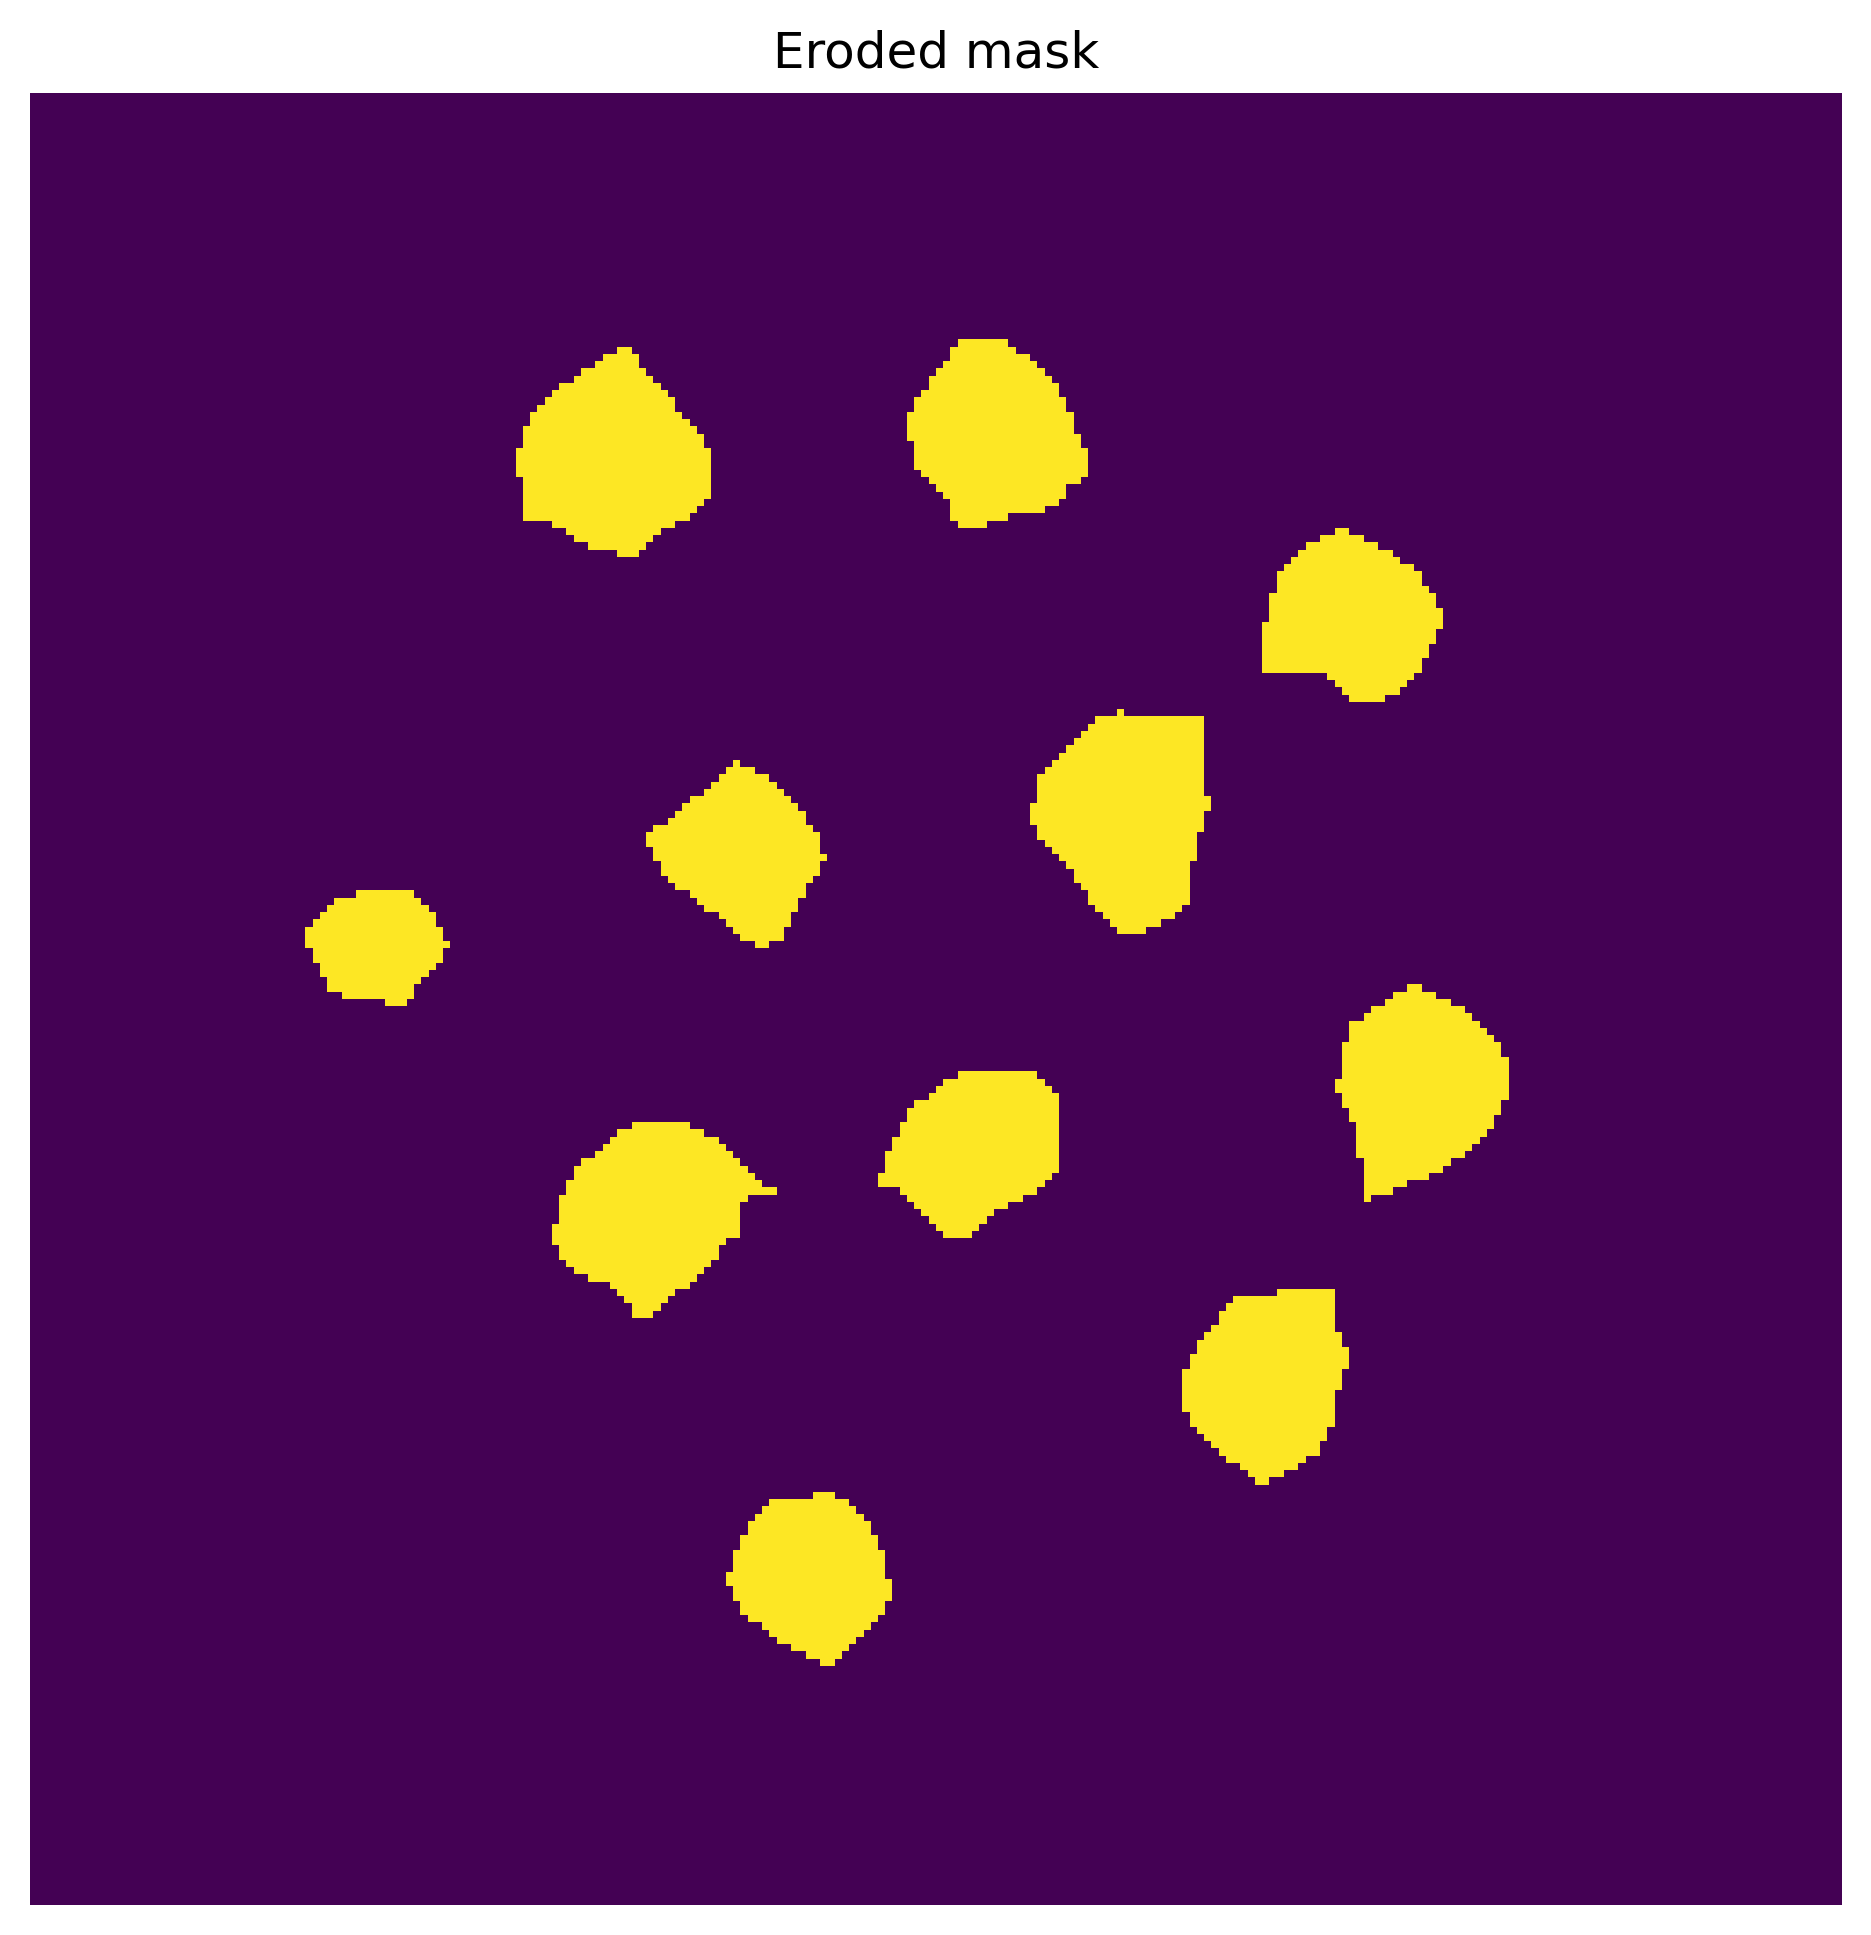

In [213]:
plt.figure(figsize=(8,8), dpi=300)
plt.imshow(mask_eroded)
plt.title('Eroded mask')
plt.axis('off')

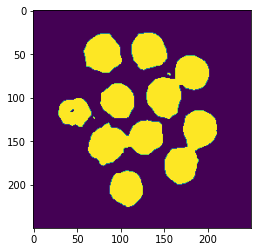

In [186]:
plt.imshow(mask)

(-0.5, 281.5, 284.5, -0.5)

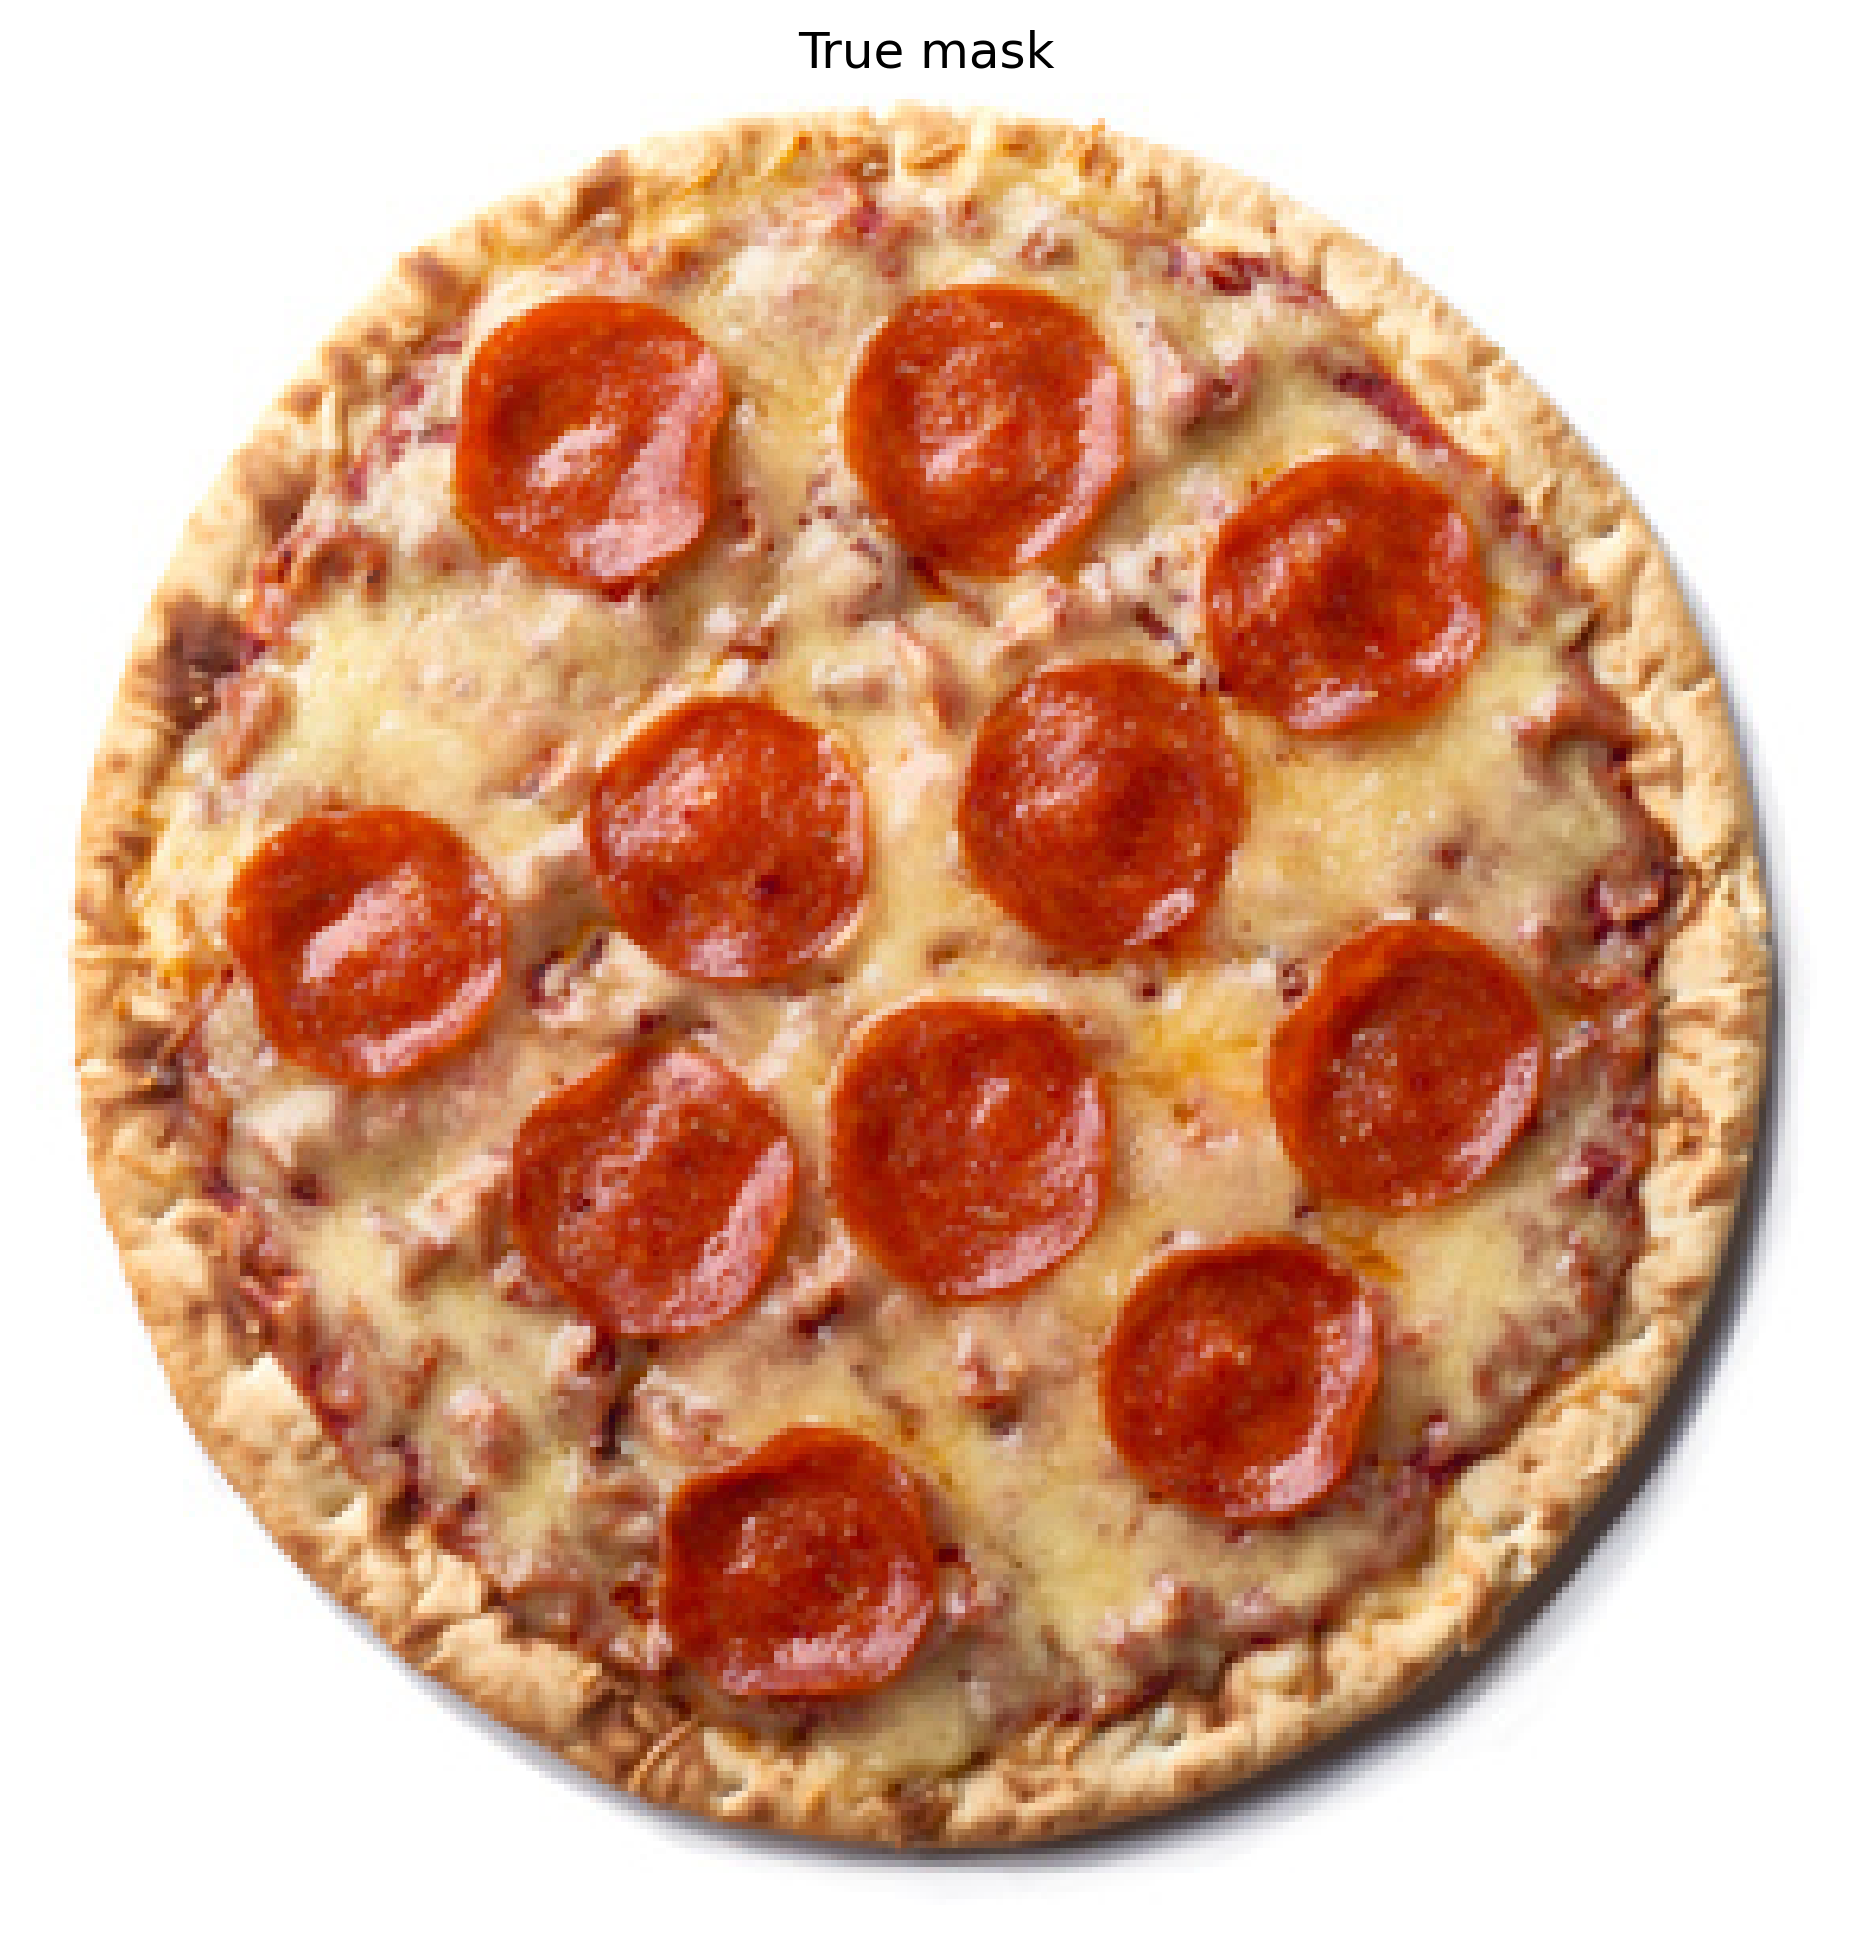

In [167]:
plt.figure(figsize=(8,8), dpi=300)
plt.imshow(im)
plt.title('True mask')
plt.axis('off')

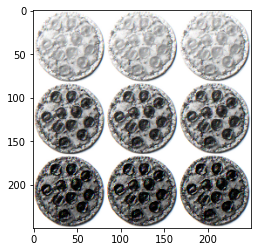

In [156]:
z = im.reshape((250, 250, 3))
plt.imshow(z)

In [161]:
import cv2


img = cv2.cvtColor(cv2.imread('IMG_2146.jpg'), cv2.COLOR_BGR2RGB)
x = cv2.resize(img, (250, 250))
x = torch.tensor(x, dtype=torch.float, device='cuda').reshape((3, 250, 250))


<Figure size 2400x2400 with 0 Axes>

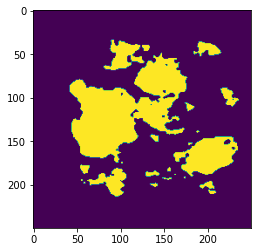

<Figure size 2400x2400 with 0 Axes>

In [163]:
plt.imshow((model_1(x[None, ...]) > 0.5).cpu().numpy()[0][0])
plt.figure(figsize=(8,8), dpi=300)

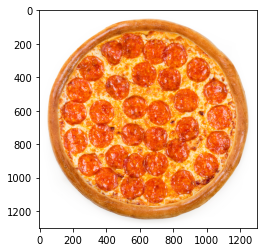

In [107]:
plt.imshow(img)

In [126]:
 torch.save(model_1.state_dict(), '/content/model.pth')

In [123]:
!ls

1.jpeg	IMG_2146.jpg  __MACOSX	new_data  new_data.zip	sample_data


In [124]:
!pwd

/content
